___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://d33wubrfki0l68.cloudfront.net/4ec62c1c925a380c912ddad740d18554c6822a11/fabe4/img/sponsors/iteso-university.png" width="300" height="500" /> 
    
    
### <font color='navy'> Modelado de pronóstico de series de tiempo. 

**Nombres:** José Luis Almendarez González, Marcela Quintero Pérez.

**Fecha:** 15 de mayo del 2025.

**Expediente** : 717644.

**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [Repositorio del proyecto - Señales EEG](https://github.com/Marcelaqprz/mnl_proyecto)

# Cerebro en Serie: Modelado y Clasificación de Señales EEG con Técnicas Clásicas y Neuronales

![Portada](https://picower.mit.edu/sites/default/files/styles/hero_1x_wide/public/Brain%20Waves%20Head%20%28web%29.jpg?h=637ed8fe&itok=GIplEvtg)

# Introducción

Las señales `electroencefalográficas (EEG)` capturan la actividad eléctrica del cerebro a través de sensores colocados sobre el cuero cabelludo, generando series de tiempo multicanal altamente complejas, no lineales y ruidosas. Este proyecto tiene como objetivo aplicar un enfoque integral de modelado de series de tiempo a mediciones EEG obtenidas mediante 19 sensores, con el fin de analizar, pronosticar y clasificar patrones neuronales.

En la primera parte del proyecto, se selecciona una señal EEG univariada para construir un modelo clásico de pronóstico basado en SARIMAX. Esto permite establecer una línea base en cuanto al comportamiento temporal de las ondas cerebrales, empleando métricas como MAPE, MSE y R² para evaluar su desempeño.

Posteriormente, se implementan y comparan distintos modelos neuronales (MLP, CNN, LSTM y CNN-LSTM) en escenarios tanto univariados como multivariados. Se entrena cada modelo utilizando múltiples arquitecturas, seleccionando y optimizando la mejor configuración a través de técnicas automáticas de ajuste de hiperparámetros como Optuna. Esta etapa resalta el valor del aprendizaje profundo en la captura de relaciones temporales y espaciales complejas presentes en las señales EEG.

Finalmente, se aborda el problema desde una perspectiva de clasificación. Para ello, se selecciona una nueva base de datos enfocada específicamente en clasificar patrones de ondas cerebrales, o bien se transforma el problema de regresión anterior en una clasificación de tendencias cerebrales (como "alta actividad", "estable", "baja actividad"). Se implementan modelos neuronales y algoritmos clásicos de Machine Learning para comparar su rendimiento en tareas de clasificación multiclase.

In [94]:
# Librerías
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns

from keras.layers import Conv2D, Dropout, Input, MaxPooling2D
from keras.utils import to_categorical

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    ConvLSTM2D,
    Dense,
    Flatten,
    InputLayer,
    LSTM,
    MaxPooling1D,
    Reshape,
    TimeDistributed
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier

# Configuración
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
seed = 123

In [95]:
df = pd.read_pickle("eeg_sintetico.pkl")

df.set_index(df.columns[0], inplace=True)

print(f"Dimensiones: {df.shape}")

df.head(5)

Dimensiones: (100, 20)


,label,FP1,FP2,F7,F8,F3,F4,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
subject_id,,,,,,,,,,,,,,,,,,,,
0,1,"[0.15587447800554355, 0.048769292252935546, 0....","[-0.6968879461070122, 0.3041051323704602, -0.2...","[0.21046417445643764, -0.5011039978323505, 0.2...","[0.18303634326083004, 0.749975949403681, -0.41...","[0.015935616742674418, -0.4551790928562453, 0....","[-0.3906596334901174, -0.14372275137743712, -0...","[0.2061201754827602, 0.26261352060634746, 0.55...","[0.5150697349605693, 0.020121574552339695, 0.2...","[-0.18269718619544859, 0.5828953992766316, -0....","[-0.40108551421875016, 0.888215263654424, 0.06...","[0.14658695189976664, 0.3196109608103265, 0.22...","[-0.18113293859735952, -0.294840608341252, -0....","[0.1386998531603244, 0.4047252273721315, 0.039...","[-0.09162155206774368, -0.5130820276219235, -0...","[0.35194813407593795, -0.024736035982895078, -...","[0.18086983683763597, -0.13258454793621965, 0....","[0.2950850184403256, -0.49017985528384994, 0.4...","[-0.24632716894730672, -0.4725025004401394, -0...","[-0.1756804040692081, -0.02965044501952376, 0...."
1,1,"[-0.03979021103450947, -0.15409787416001966, 0...","[-0.024155503243054738, -0.15408441134477466, ...","[-0.3886884401035693, -0.005604558802166581, -...","[-0.24523298784390293, -0.6000420524696534, -0...","[0.11066005471842116, 0.5110741339575443, -0.0...","[0.33077560454690697, -0.24159651232014817, 0....","[0.34660487797241823, -0.039803236740678996, 0...","[0.02580488016898886, 0.18312879701770632, -0....","[0.3054946651477372, -0.28988075224952364, 0.3...","[0.04148731827688728, -0.4147464802531556, 0.4...","[-0.00736988370343126, -0.28822981134508396, 0...","[-0.19501003683079532, 0.38585018662985887, 0....","[-0.08849100491022789, 0.20587977222299944, -0...","[0.3196469240800905, 0.8507797255650871, -0.43...","[-0.5802213149079919, 0.38811112920811786, -0....","[0.3875610412004299, -0.45831180964543644, -0....","[0.030784914240578564, 0.04455984603183623, -0...","[-0.3852053398712488, 0.05830688683541568, -0....","[-0.11758727562431871, -0.1776706278108205, 0...."
2,1,"[-0.7308852577782832, 0.6331634483447823, 0.18...","[0.14340017834713065, -0.41708651789155976, -0...","[0.5997492234290559, -0.26547970400070653, -0....","[0.2524784363902365, -0.27995076798093665, 0.1...","[0.4223506579931446, 0.40185920250899615, -0.0...","[0.7281394235840116, -0.5087121383215768, 0.46...","[-0.7755418652479512, -0.0788045211090522, -0....","[-0.6808254913360005, 0.0024041062399791273, 0...","[0.1643469712391745, -0.41242548666380513, 0.6...","[0.2247150984377684, -0.07912830588442449, -0....","[0.010792093762172755, 0.6388023807499378, -0....","[-0.7910330202396902, 0.5322224926701894, 0.09...","[0.896112963081652, 0.2259160601161496, -0.850...","[-0.6171890406969667, -0.001500307615138619, -...","[0.7174894105901409, 0.3102244820488897, 0.104...","[0.017696120108697345, 0.609504496434134, 0.36...","[-0.09255084527561272, -0.3383512050992671, 0....","[-0.4079899243538443, -0.40957857315730495, -0...","[0.2693127846006996, 0.8492481791217846, 0.125..."
3,1,"[0.13926135016669713, 0.31341738685791276, -0....","[0.7251229185054089, 0.05740628040619821, 0.62...","[0.10858850675719665, -0.15933229941815893, -0...","[0.0168885887953725, 0.09756864990030252, 0.50...","[-0.30985037940465965, 0.18449691148771832, 0....","[0.03875734841802368, -0.005762306493915205, 0...","[0.11295279464044487, 0.19612264223823347, 0.0...","[-0.35660276445858197, 0.24687397929716368, 0....","[0.03178141918954638, -0.2244869328042958, 0.0...","[0.5614452962438603, -0.3916662485849009, 0.35...","[-0.16242306237856635, -0.3622261056353095, -0...","[-0.37409621666022697, 0.197470025712021, 0.29...","[-0.532842898115002, -0.46019606784703526, -0....","[0.0339680712018202, -0.23731137069794478, -0....","[-0.04048277265618861, 0.4552294299090003, 0.3...","[-0.342336720037937, 0.01792720335064462, 0.01...","[-0.31256621264992845, 0.19301301663607726, 0....","[-0.026360605283680373, 0.276133783514

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   100 non-null    int64 
 1   FP1     100 non-null    object
 2   FP2     100 non-null    object
 3   F7      100 non-null    object
 4   F8      100 non-null    object
 5   F3      100 non-null    object
 6   F4      100 non-null    object
 7   T3      100 non-null    object
 8   T4      100 non-null    object
 9   C3      100 non-null    object
 10  C4      100 non-null    object
 11  T5      100 non-null    object
 12  T6      100 non-null    object
 13  P3      100 non-null    object
 14  P4      100 non-null    object
 15  O1      100 non-null    object
 16  O2      100 non-null    object
 17  Fz      100 non-null    object
 18  Cz      100 non-null    object
 19  Pz      100 non-null    object
dtypes: int64(1), object(19)
memory usage: 16.4+ KB


In [97]:
for col in df.columns[2:]:  # Ignorando subject_id y label
    values = np.concatenate(df[col].values)
    print(f"{col} - mean: {np.mean(values):.4f}, std: {np.std(values):.4f}, min: {np.min(values):.4f}, max: {np.max(values):.4f}")

FP2 - mean: 0.0260, std: 0.7466, min: -2.6495, max: 2.4987
F7 - mean: 0.0088, std: 0.7459, min: -2.7848, max: 2.8800
F8 - mean: 0.0074, std: 0.7475, min: -2.5058, max: 2.5697
F3 - mean: 0.0313, std: 0.7474, min: -2.6552, max: 2.8191
F4 - mean: 0.0314, std: 0.7459, min: -2.6406, max: 2.6972
T3 - mean: 0.0686, std: 0.7504, min: -2.6854, max: 2.7995
T4 - mean: 0.0706, std: 0.7477, min: -2.7257, max: 2.5679
C3 - mean: 0.0697, std: 0.7487, min: -2.5551, max: 2.6789
C4 - mean: 0.0704, std: 0.7501, min: -2.7769, max: 3.0306
T5 - mean: 0.0075, std: 0.7470, min: -2.6986, max: 2.6029
T6 - mean: 0.0081, std: 0.7473, min: -2.5063, max: 2.6689
P3 - mean: 0.0074, std: 0.7476, min: -3.1825, max: 2.5445
P4 - mean: 0.0074, std: 0.7458, min: -2.8405, max: 2.5886
O1 - mean: 0.0026, std: 0.7509, min: -2.6409, max: 2.7230
O2 - mean: 0.0026, std: 0.7533, min: -2.6119, max: 2.6403
Fz - mean: 0.0068, std: 0.7474, min: -2.8126, max: 2.5542
Cz - mean: 0.0075, std: 0.7473, min: -3.0273, max: 2.5844
Pz - mean: 0.

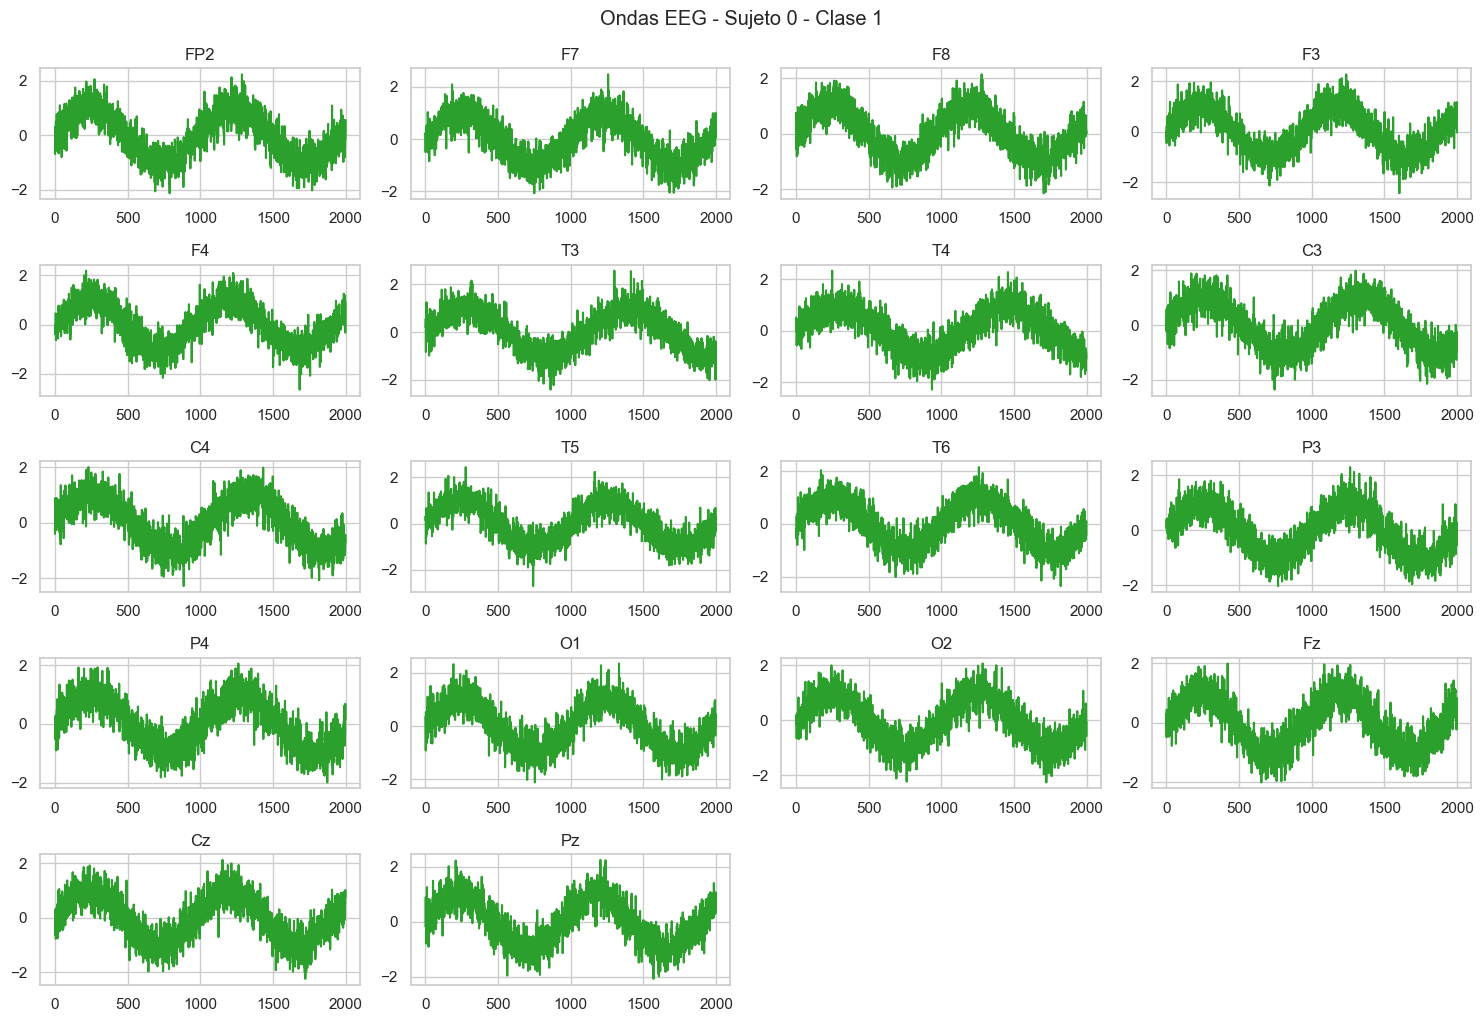

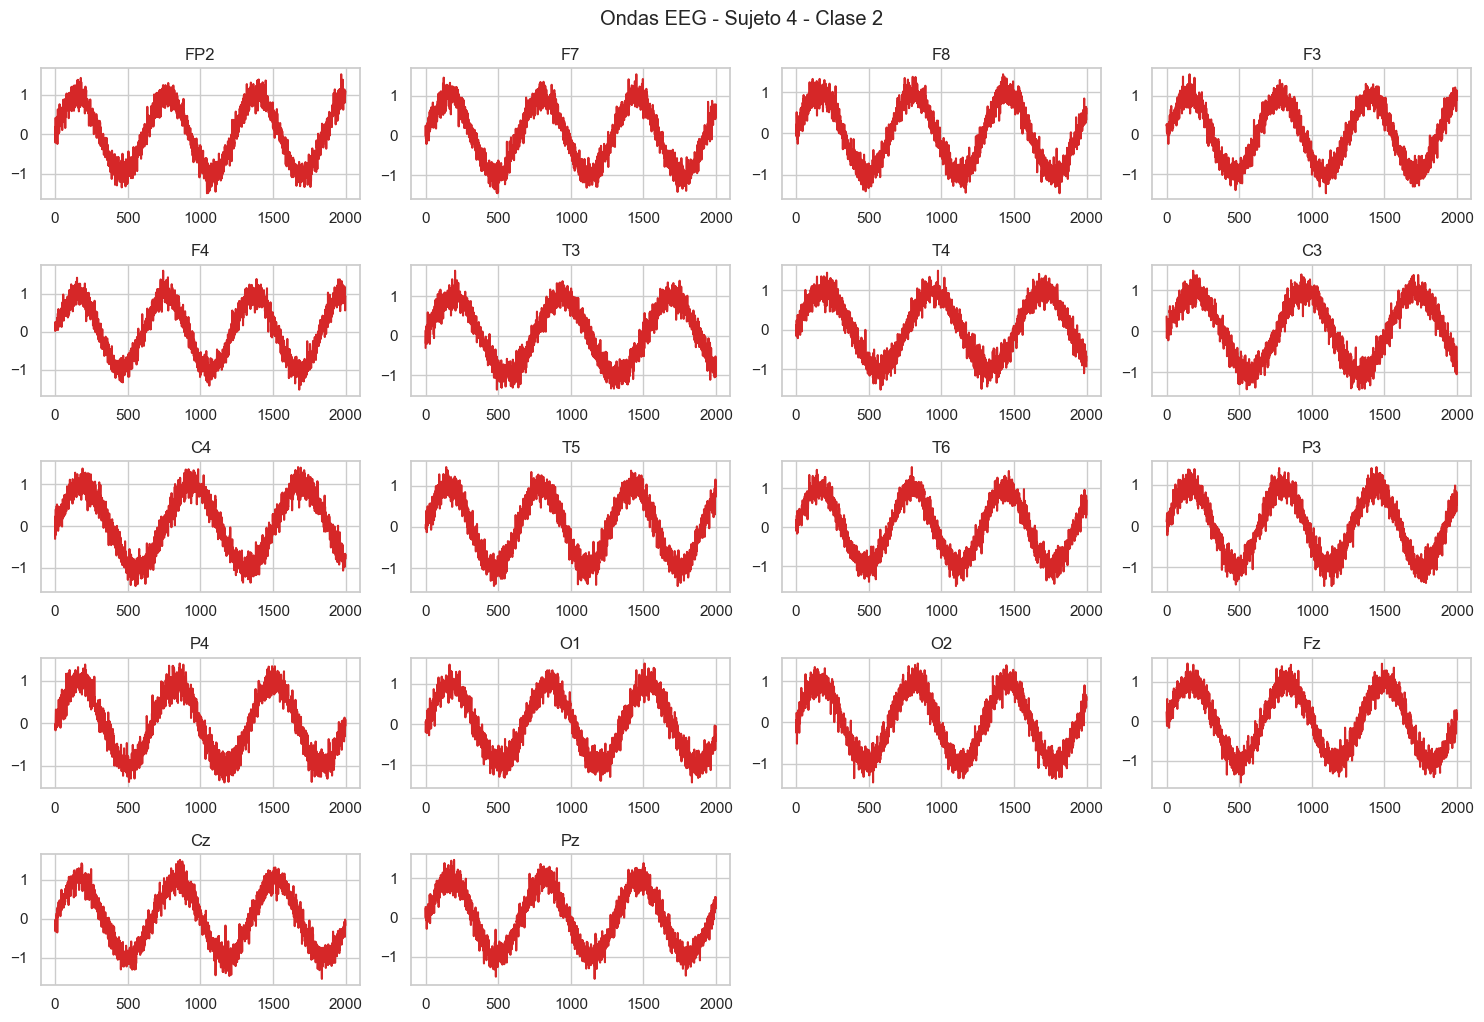

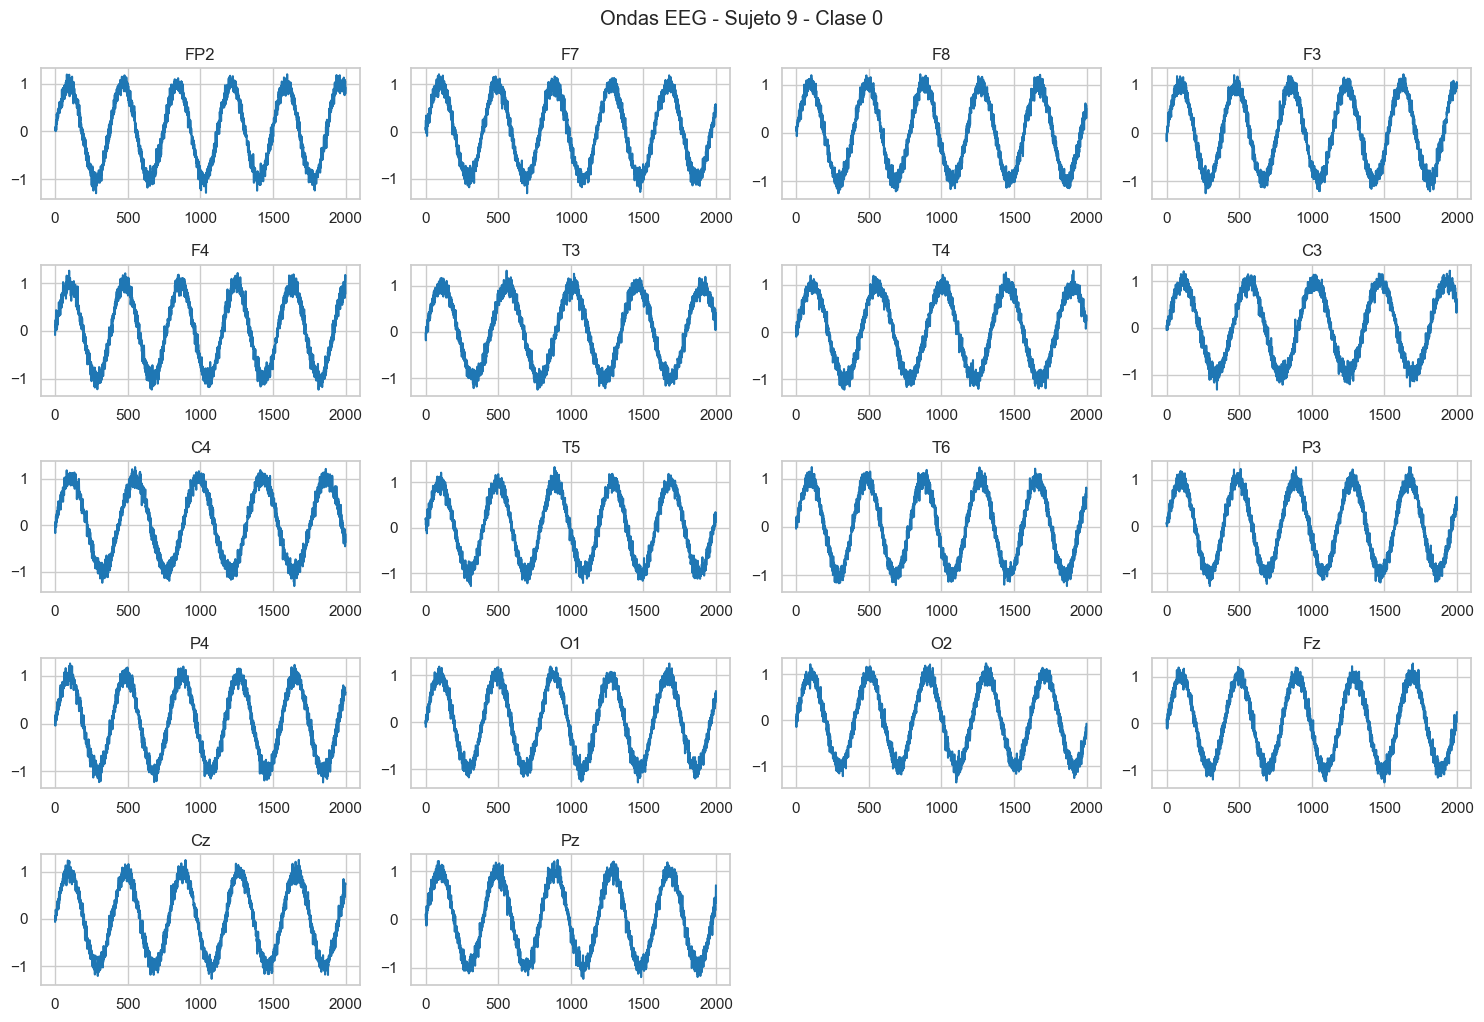

In [106]:
# Columnas de sensores (sin 'subject_id' ni 'label')
sensor_cols = df.columns[2:]

# Colores por clase
class_colors = {
    0: 'tab:blue',
    1: 'tab:green',
    2: 'tab:red'
}

# Obtener un ejemplo por cada clase
unique_labels = df['label'].unique()
examples = [df[df['label'] == lbl].iloc[0] for lbl in unique_labels]

# Función para graficar los 19 sensores de un sujeto con color
def plot_subject_eeg(subject_row, subject_id, label):
    color = class_colors.get(label, 'black')  # color por clase
    plt.figure(figsize=(15, 10))
    for i, sensor in enumerate(sensor_cols):
        plt.subplot(5, 4, i+1)
        plt.plot(subject_row[sensor], color=color)
        plt.title(sensor)
        plt.tight_layout()
    plt.suptitle(f'Ondas EEG - Sujeto {subject_id} - Clase {label}', y=1.02)
    plt.show()

# Graficar una muestra por clase
for row in examples:
    plot_subject_eeg(row, row.name, row['label'])

Valores por label: label
1    36
2    33
0    31
Name: count, dtype: int64


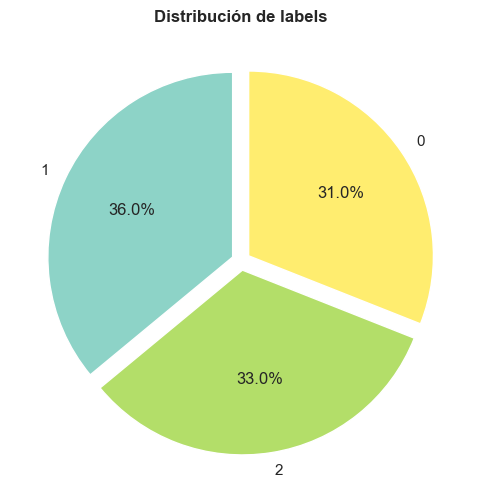

In [98]:
counts = df['label'].value_counts()

print(f"Valores por label: {counts}")

plt.figure(figsize=(6,6))
counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', explode=[0.05]*len(counts))
plt.title('Distribución de labels', fontweight='bold')
plt.ylabel('')

plt.show()

# Desarrollo

Las señales utilizadas en este proyecto provienen de registros EEG multicanal, obtenidos mediante un conjunto de 19 sensores dispuestos sobre el cuero cabelludo de cada sujeto. La colocación de los sensores sigue típicamente el estándar internacional 10-20, utilizado ampliamente en neurociencia clínica e investigativa para garantizar la replicabilidad y consistencia espacial de las mediciones.

Cada canal (sensor) registra la actividad eléctrica cerebral en una ubicación específica, reflejando fenómenos neuronales relacionados con funciones motoras, cognitivas o sensoriales, dependiendo del área cortical correspondiente. Estas señales conforman series temporales continuas con alta resolución temporal y pueden verse afectadas por ruido, artefactos y variaciones individuales, lo que hace crucial el uso de técnicas robustas para su modelado y análisis.

A continuación, se presenta una imagen referencial de la disposición típica de los electrodos en un registro EEG:

![EEG](https://www.researchgate.net/profile/Iqram-Hussain/publication/346700844/figure/fig2/AS:966299295440896@1607395113741/Description-of-device-electrodes-layout-used-in-experiment-a-positions-of-EEG.png)


## 1. Análisis y pronóstico de series de tiempo
Obj: Mostrar competencia de aprendizaje Modelos lineales de regresión

### EEG

In [4]:
sensor_cols = ['FP1', 'FP2', 'F7', 'F8', 'F3', 'F4', 'T3', 'T4',
               'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2',
               'Fz', 'Cz', 'Pz']

# Asegurar que todas las columnas contengan arrays de NumPy
for col in sensor_cols:
    df[col] = df[col].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)

# Calcular la media por sujeto (por fila), punto a punto
df['wave_mean'] = df[sensor_cols].apply(lambda row: np.mean(np.vstack(row.values), axis=0), axis=1)

In [5]:
# Datos univariados
random_row = df.iloc[93]

wave = random_row.wave_mean

# Crear eje de tiempo (de 1 a 2000)
t = np.arange(1, len(wave) + 1)

# Crear DataFrame de la serie de tiempo
ts = pd.Series(wave, index=t)

ts.index = pd.date_range(start="2020-01-01", periods=len(ts), freq="D")

ts

2020-01-01   -0.008081
2020-01-02   -0.022480
2020-01-03    0.043144
2020-01-04    0.077575
2020-01-05    0.046199
                ...   
2025-06-18    0.488267
2025-06-19    0.506256
2025-06-20    0.450273
2025-06-21    0.499471
2025-06-22    0.486438
Freq: D, Length: 2000, dtype: float64

<Axes: >

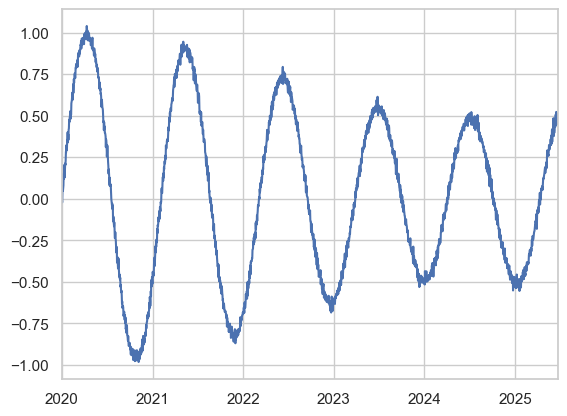

In [7]:
ts.plot()

<Axes: >

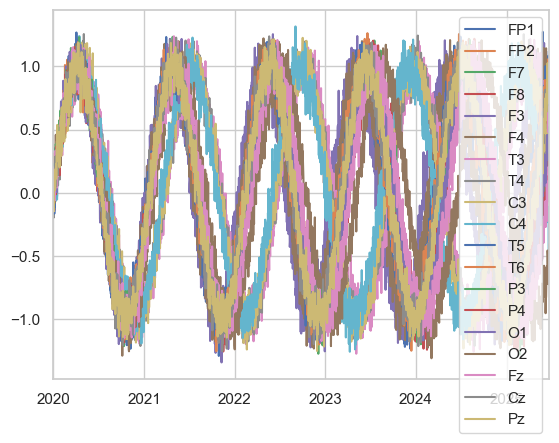

In [6]:
# Datos multivariados
random_row = df.iloc[93]

# Diccionario con las series de cada sensor
sensor_data = {sensor: random_row[sensor] for sensor in sensor_cols}

ts_multivar = pd.DataFrame(sensor_data)

ts_multivar.index = pd.date_range(start="2020-01-01", periods=len(ts_multivar), freq="D")

ts_multivar # cada valor individual del array está en su propia fila

# Serie temporal por sensor (tenemos 19 sensores)
ts_multivar.plot()

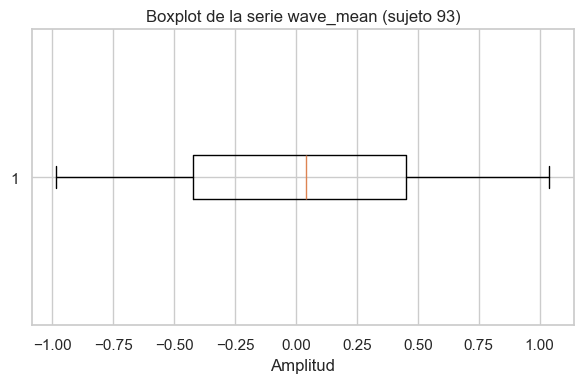

In [8]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

A continuación, se realiza un reescalado de la serie al rango [0,1] para garantizar que todos los valores sean positivos, condición necesaria para aplicar la transformación de Box-Cox. Esta transformación busca estabilizar la varianza y acercar la distribución de los datos a una forma aproximadamente normal, lo cual resulta especialmente útil para modelos lineales y redes neuronales sensibles a la distribución de entrada. Finalmente, se aplica un pequeño desplazamiento hacia arriba para asegurar que todos los valores transformados permanezcan estrictamente positivos y evitar problemas numéricos durante el procesamiento.

<Axes: title={'center': 'Box-Cox (shifted positive)'}>

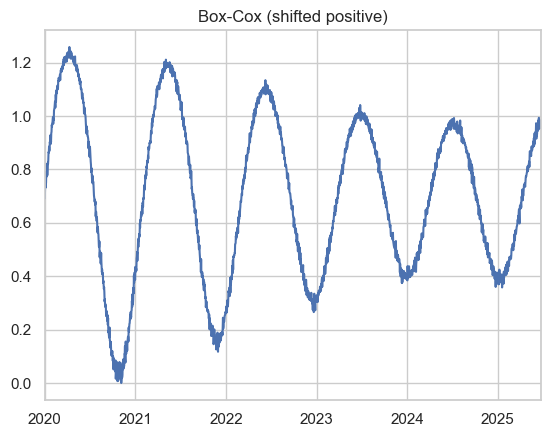

In [9]:
ts_rescaled = (ts + 1) / 2  # Esto asegura que -1 → 0 y 1 → 1
from scipy import stats

ts_boxcox, lambda_ = stats.boxcox(ts_rescaled)
ts_boxcox = pd.Series(ts_boxcox, index=ts.index)

ts_boxcox_shifted = ts_boxcox - ts_boxcox.min() + 1e-5
ts_boxcox_shifted.plot(title="Box-Cox (shifted positive)")

Graficamos de nuevo el box-plot para corroborar la escala del gráfico:

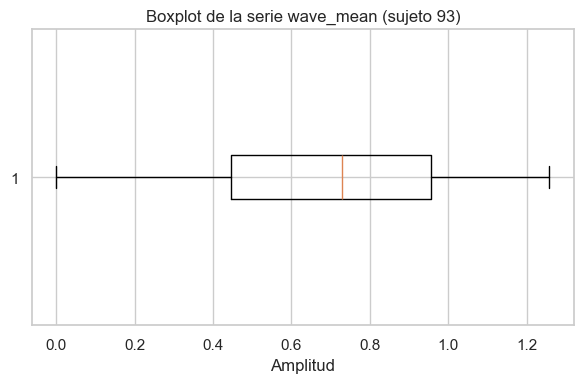

In [10]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts_boxcox_shifted, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

Para evaluar la estacionariedad de la serie de tiempo, se aplica el test de Dickey-Fuller Aumentado (ADF). Esta prueba estadística nos permite verificar si una serie presenta una raíz unitaria, lo que indicaría que es no estacionaria. En términos prácticos, la estacionariedad implica que las propiedades estadísticas de la serie (como la media y la varianza) son constantes a lo largo del tiempo, lo cual es una premisa clave para muchos modelos de pronóstico.

Si el p-valor de la prueba ADF es bajo (generalmente menor a 0.05), podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que indica que la serie es estacionaria. Esto significa que la serie no necesita ser transformada adicionalmente antes de aplicar modelos como ARIMA o redes neuronales.

En cambio, si el p-valor es alto, no podemos rechazar la hipótesis nula y, por lo tanto, la serie se considera no estacionaria. En este caso, puede ser necesario aplicar técnicas adicionales como diferenciación o transformaciones (como el logaritmo o la Box-Cox) para hacer la serie estacionaria antes de continuar con el modelado.

In [11]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
adf_test(ts_boxcox_shifted)

Results of Dickey-Fuller Test:
Test Statistic                -1.298482e+01
p-value                        2.893004e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


Tras aplicar el test de Dickey-Fuller Aumentado (ADF), se ha confirmado que la serie de tiempo es estacionaria, con un p-valor de 2.89e-24, lo que permite rechazar la hipótesis nula de la presencia de una raíz unitaria. Esto indica que la serie cumple con los requisitos necesarios para aplicar modelos como SARIMAX, los cuales son adecuados para series de tiempo con componentes estacionales y dependencias temporales.

El siguiente paso en el análisis es realizar una descomposición MSTL (Seasonal-Trend decomposition using Loess), que nos permitirá descomponer la serie en sus componentes clave: estacionalidad, tendencia y residuales. Esta descomposición es esencial para entender mejor los patrones subyacentes de la serie y para asegurar que los efectos estacionales sean capturados adecuadamente antes de ajustar el modelo.

Luego de obtener los componentes estacionales, de tendencia y residuales, se realiza nuevamente el test ADF sobre cada uno de ellos para confirmar que no existan problemas de no estacionariedad que puedan afectar la modelización futura. La descomposición no solo facilita una mejor comprensión de la dinámica de la serie, sino que también puede ofrecer pistas sobre qué componentes estacionales deben ser modelados de manera específica en el SARIMAX. Así, aseguramos que el modelo pueda capturar tanto las dependencias de corto plazo como los efectos estacionales, lo que maximiza su capacidad predictiva.

In [13]:
def mstl_descomposition(data, periods_seasonality, stl_kwargs=None):
    if stl_kwargs is None:
        stl_kwargs = {"seasonal_deg": 0}

    model = MSTL(data, periods=periods_seasonality, stl_kwargs=stl_kwargs)
    res = model.fit()

    fig, ax = plt.subplots(3 + len(periods_seasonality), 1, sharex=True, figsize=(8, 8))

    res.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')

    res.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')

    for i, s_period in enumerate(periods_seasonality):
        res.seasonal[f'seasonal_{s_period}'].plot(ax=ax[i + 2])
        ax[i + 2].set_ylabel(f'seasonal_{s_period}')

    res.resid.plot(ax=ax[2 + len(periods_seasonality)])
    ax[2 + len(periods_seasonality)].set_ylabel('Residual')

    fig.tight_layout()
    return res

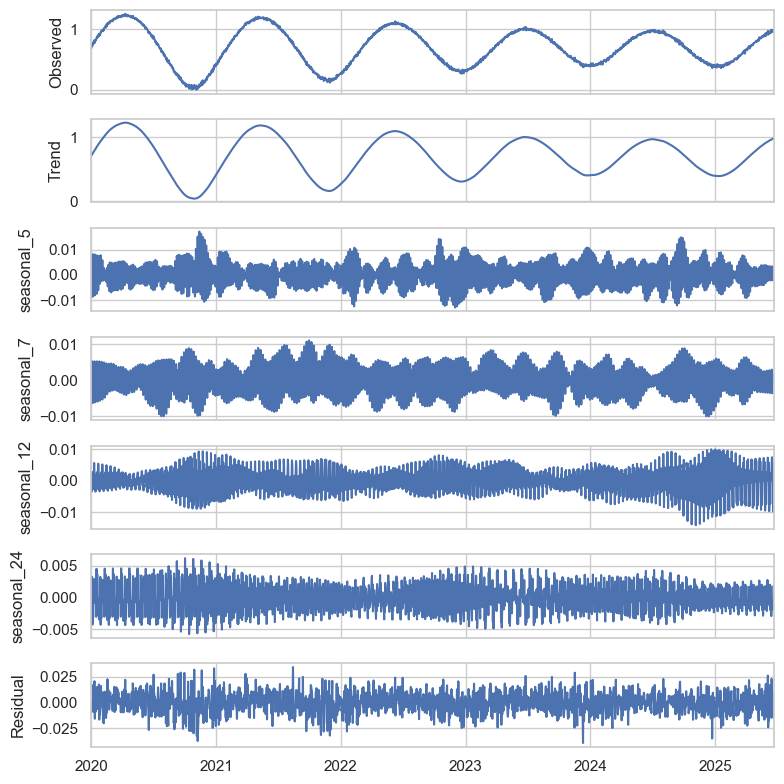

In [14]:
periods_seasonality = (5 ,7 ,12, 24)

desc = mstl_descomposition(ts_boxcox_shifted, periods_seasonality)

In [15]:
# Lista de los componentes estacionales y residuales
components = ['seasonal_5', 'seasonal_7', 'seasonal_12', 'seasonal_24', 'residuals']

# Iterar sobre los componentes y aplicar el test ADF
for component in components:
    print(f"\n{component}")
    # Si el componente no está en 'desc.seasonal', usa 'desc.resid'
    adf_test(desc.seasonal.get(component, desc.resid))  
    print()


seasonal_5
Results of Dickey-Fuller Test:
Test Statistic                  -19.202710
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1974.000000
Critical Value (1%)              -3.433667
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64
Stationary


seasonal_7
Results of Dickey-Fuller Test:
Test Statistic                -1.335810e+01
p-value                        5.496851e-25
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                -1.621373e+01
p-value                        3.962143e-29
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -

Con base en estos resultados, podemos concluir que todos los componentes estacionales y los residuos de la serie son estacionarios, lo que significa que la serie de tiempo es adecuada para ser modelada con métodos como SARIMAX, sin necesidad de transformaciones adicionales de diferenciación. La confirmación de la estacionariedad de los residuos es particularmente importante, ya que garantiza que no hay patrones temporales no capturados que puedan influir en el modelo.

Ahora, con la serie ya comprobada como estacionaria, el siguiente paso es realizar un análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los parámetros adecuados del modelo AR (autoregresivo) y MA (media móvil). Esto nos ayudará a ajustar el modelo SARIMAX y a capturar las dependencias temporales y los efectos estacionales de manera más precisa.

In [16]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

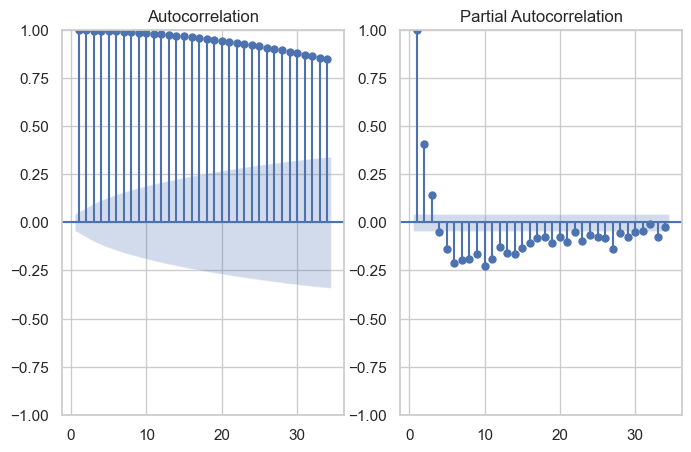

In [17]:
plot_acf_pacf(ts_boxcox_shifted)

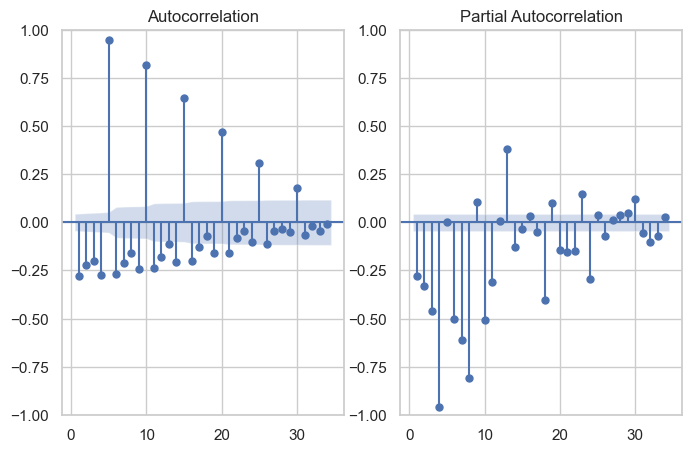

In [18]:
plot_acf_pacf(desc.seasonal['seasonal_5'])

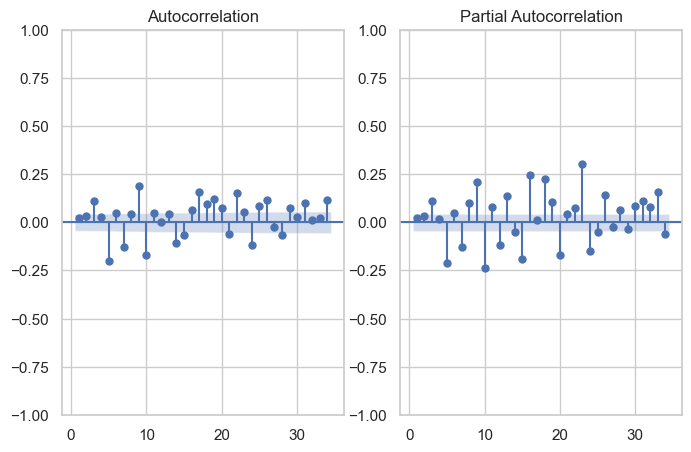

In [19]:
plot_acf_pacf(desc.resid)

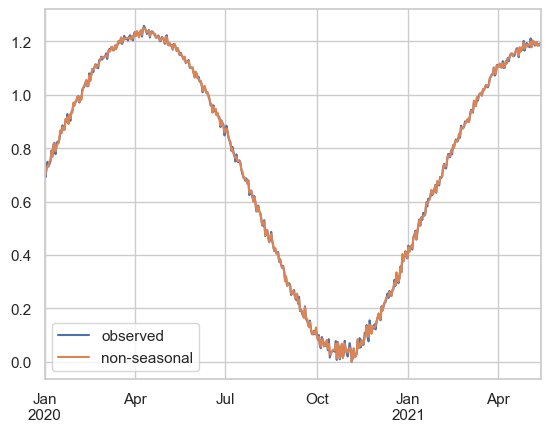

In [20]:
non_seasonal = desc.observed - desc.seasonal['seasonal_5'] - desc.seasonal['seasonal_7']

desc.observed[:500].plot()
non_seasonal[:500].plot()
plt.legend(['observed', 'non-seasonal'])

In [21]:
adf_test(non_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -1.314541e+01
p-value                        1.401610e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


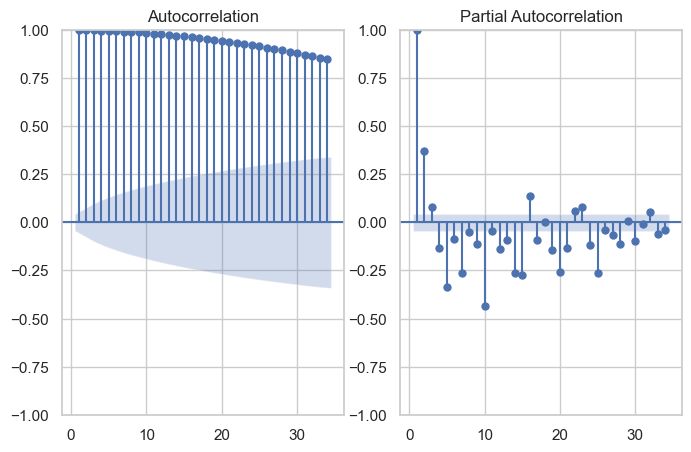

In [22]:
plot_acf_pacf(non_seasonal)

In [23]:
n_train = int(0.8 * len(ts_boxcox_shifted))
n_test = len(ts_boxcox_shifted) - n_train

train_data_opt = ts_boxcox_shifted[:n_train]
test_data_opt = ts_boxcox_shifted[-n_test:]

# Crear características de seno y coseno
ts_sin = np.sin(np.linspace(0, len(train_data_opt), len(train_data_opt)))
ts_cos = np.cos(np.linspace(0, len(train_data_opt), len(train_data_opt)))

# Añadir las características al modelo
train_data_opt = pd.DataFrame({
    'sin_component': ts_sin,
    'cos_component': ts_cos,
    'target': train_data_opt
})

# Crear características de seno y coseno para test
ts_sin_test = np.sin(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))
ts_cos_test = np.cos(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))

test_exog = pd.DataFrame({
    'sin_component': ts_sin_test,
    'cos_component': ts_cos_test
}, index=test_data_opt.index)  # importante mantener el índice

In [24]:
# Suponiendo que `ts` es tu serie temporal
model = SARIMAX(
    train_data_opt['target'],
    exog=train_data_opt[['sin_component', 'cos_component']],
    order=(1, 1, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              target   No. Observations:                 1600
Model:             SARIMAX(1, 1, 2)x(3, 2, [1], 7)   Log Likelihood                4080.322
Date:                             Thu, 15 May 2025   AIC                          -8140.645
Time:                                     18:19:20   BIC                          -8087.101
Sample:                                 01-01-2020   HQIC                         -8120.739
                                      - 05-18-2024                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sin_component    -0.0005      0.000     -1.509      0.131      -0.001       0.000
cos_component    -

RMSE (Box-Cox): 0.9510
MAE  (Box-Cox): 0.8275


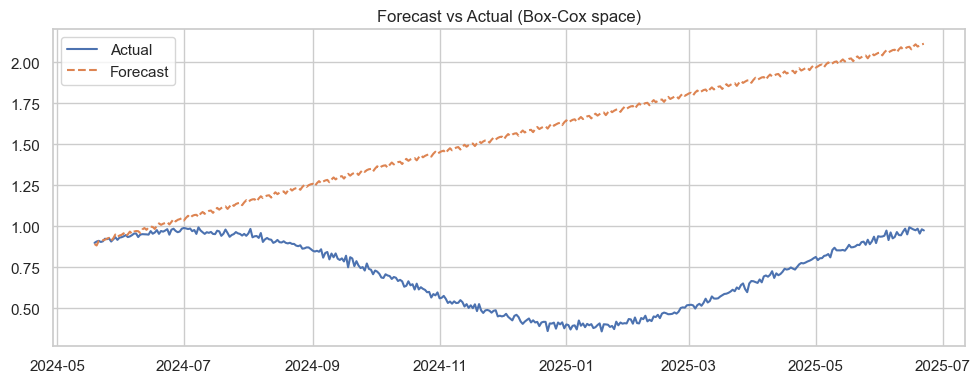

In [25]:
# 2. Predicción
forecast = results.get_forecast(steps=len(test_data_opt), exog=test_exog)
predicted_mean = forecast.predicted_mean

# 3. Evaluación
rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
mae = mean_absolute_error(test_data_opt, predicted_mean)

print(f'RMSE (Box-Cox): {rmse:.4f}')
print(f'MAE  (Box-Cox): {mae:.4f}')

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(test_data_opt.index, test_data_opt, label='Actual')
plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
plt.title('Forecast vs Actual (Box-Cox space)')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
train_data_opt

,sin_component,cos_component,target
2020-01-01,0.000000,1.000000,0.699736
2020-01-02,0.841809,0.539776,0.691375
2020-01-03,0.908776,-0.417284,0.729276
2020-01-04,0.139262,-0.990256,0.748959
2020-01-05,-0.758435,-0.651748,0.731028
...,...,...,...
2024-05-14,0.068377,0.997660,0.882167
2024-05-15,0.876747,0.480952,0.884458
2024-05-16,0.878117,-0.478447,0.867090
2024-05-17,0.071226,-0.997460,0.896977


In [27]:
test_data_opt

2024-05-19    0.897865
2024-05-20    0.905932
2024-05-21    0.910424
2024-05-22    0.903397
2024-05-23    0.907220
                ...   
2025-06-18    0.974727
2025-06-19    0.984289
2025-06-20    0.954453
2025-06-21    0.980685
2025-06-22    0.973754
Freq: D, Length: 400, dtype: float64

In [28]:
# Define los rangos máximos (basado en tus valores)
p = [1,2,3]
d = [1,2,3]
q = [1,2,3]

P = [3]
D = [2]
Q = [1]

s = 7  # Periodo estacional

# Generar todas las combinaciones posibles
orders = list(itertools.product(p, d, q))
seasonal_orders = list(itertools.product(P, D, Q))

# Inicializar variables para almacenar el mejor modelo
best_rmse = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# Loop de búsqueda
for order in orders:
    for seasonal in seasonal_orders:
        try:
            model = SARIMAX(train_data_opt,
                            order=order,
                            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # 2. Predicción
            forecast = results.get_forecast(steps=len(test_data_opt))
            predicted_mean = forecast.predicted_mean

            # 3. Evaluación
            rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
            mae = mean_absolute_error(test_data_opt, predicted_mean)

            # Mostrar las métricas de rendimiento
            print(f"Modelo SARIMA{order} x {seasonal}7")
            print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

            # Graficar la predicción vs la realidad (en escala Box-Cox)
            plt.figure(figsize=(10, 4))
            plt.plot(test_data_opt.index, test_data_opt, label='Actual')
            plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
            plt.title(f'Forecast vs Actual (SARIMA{order} x {seasonal}7)')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Si el modelo actual tiene un RMSE menor, lo actualizamos como el mejor
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal
                best_model = results
                print(f"NUEVO MEJOR MODELO: SARIMA{order} x {seasonal}7 con RMSE={rmse:.4f}")

        except Exception as e:
            print(f"Error con orden={order} y seasonal={seasonal}: {e}")
            continue

print("\n--- Mejor modelo encontrado ---")
print(f"Orden: {best_order}")
print(f"Orden estacional: {best_seasonal_order}7")
print(f"RMSE: {best_rmse:.4f}")

Error con orden=(1, 1, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 1, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 1, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (16

### INPC Mensual

In [79]:
df2 = pd.read_csv("conjunto_de_datos_inpc_mensual.csv")
df2.head()

,Data
0,42.679965
1,42.108075
2,43.014831
3,53.525441
4,57.447814


<Axes: >

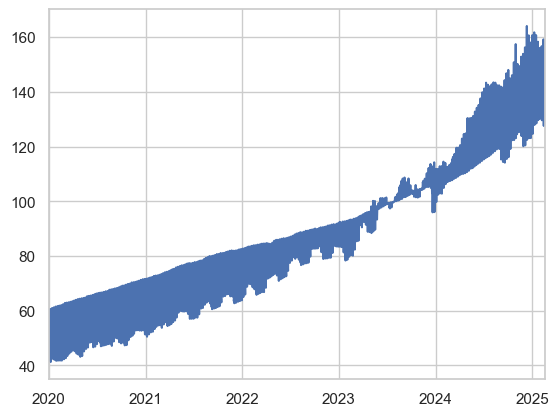

In [80]:
serie = df2.Data
t = np.arange(1, len(serie))
ts = pd.Series(serie, index=t)
ts.index = pd.date_range(start="2020-01-01", periods=len(ts), freq="D")
ts.plot()

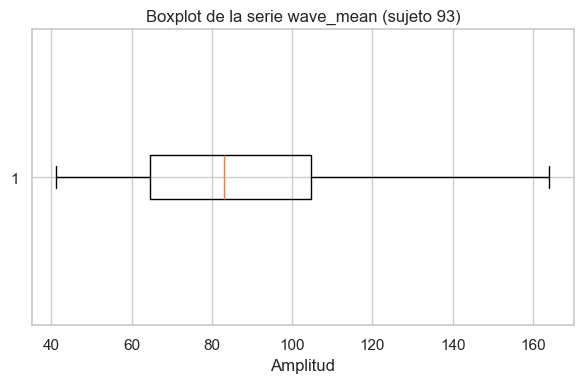

In [81]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

In [82]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

Results of Dickey-Fuller Test:
Test Statistic                    2.662322
p-value                           0.999084
#Lags Used                       24.000000
Number of Observations Used    1850.000000
Critical Value (1%)              -3.433890
Critical Value (5%)              -2.863104
Critical Value (10%)             -2.567602
dtype: float64
Non-stationary
Results of Dickey-Fuller Test:
Test Statistic                -8.786669e+00
p-value                        2.298734e-14
#Lags Used                     2.400000e+01
Number of Observations Used    1.826000e+03
Critical Value (1%)           -3.433936e+00
Critical Value (5%)           -2.863124e+00
Critical Value (10%)          -2.567613e+00
dtype: float64
Stationary


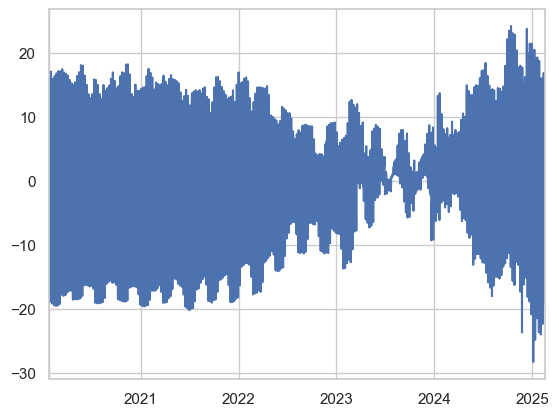

In [83]:
adf_test(ts)
ts_diff1 = ts.diff().dropna()
ts_diff2 = ts.diff(24).dropna()  # cambia 24 por tu periodo estacional si aplica
ts_diff2.plot()
adf_test(ts_diff2)

In [84]:
def mstl_descomposition(data, periods_seasonality, stl_kwargs=None):
    if stl_kwargs is None:
        stl_kwargs = {"seasonal_deg": 0}

    model = MSTL(data, periods=periods_seasonality, stl_kwargs=stl_kwargs)
    res = model.fit()

    fig, ax = plt.subplots(3 + len(periods_seasonality), 1, sharex=True, figsize=(8, 8))

    res.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')

    res.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')

    for i, s_period in enumerate(periods_seasonality):
        res.seasonal[f'seasonal_{s_period}'].plot(ax=ax[i + 2])
        ax[i + 2].set_ylabel(f'seasonal_{s_period}')

    res.resid.plot(ax=ax[2 + len(periods_seasonality)])
    ax[2 + len(periods_seasonality)].set_ylabel('Residual')

    fig.tight_layout()
    return res

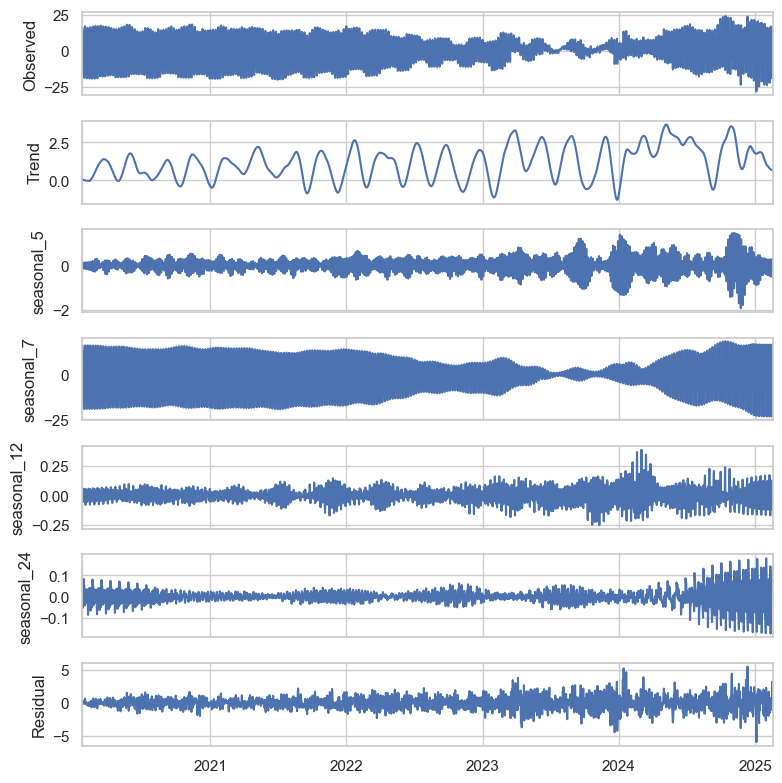

In [85]:
periods_seasonality = (5 ,7 ,12, 24)
desc = mstl_descomposition(ts_diff2, periods_seasonality)

In [86]:
components = ['seasonal_5', 'seasonal_7', 'seasonal_12', 'seasonal_24', 'residuals']

for component in components:
    print(f"\n{component}")
    adf_test(desc.seasonal.get(component, desc.resid))
    print()


seasonal_5
Results of Dickey-Fuller Test:
Test Statistic                -1.307479e+01
p-value                        1.924055e-24
#Lags Used                     2.500000e+01
Number of Observations Used    1.825000e+03
Critical Value (1%)           -3.433938e+00
Critical Value (5%)           -2.863125e+00
Critical Value (10%)          -2.567614e+00
dtype: float64
Stationary


seasonal_7
Results of Dickey-Fuller Test:
Test Statistic                -1.279708e+01
p-value                        6.879421e-24
#Lags Used                     2.500000e+01
Number of Observations Used    1.825000e+03
Critical Value (1%)           -3.433938e+00
Critical Value (5%)           -2.863125e+00
Critical Value (10%)          -2.567614e+00
dtype: float64
Stationary


seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                -9.626492e+00
p-value                        1.655310e-16
#Lags Used                     2.500000e+01
Number of Observations Used    1.825000e+03
Critical Value (1%)     

In [87]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

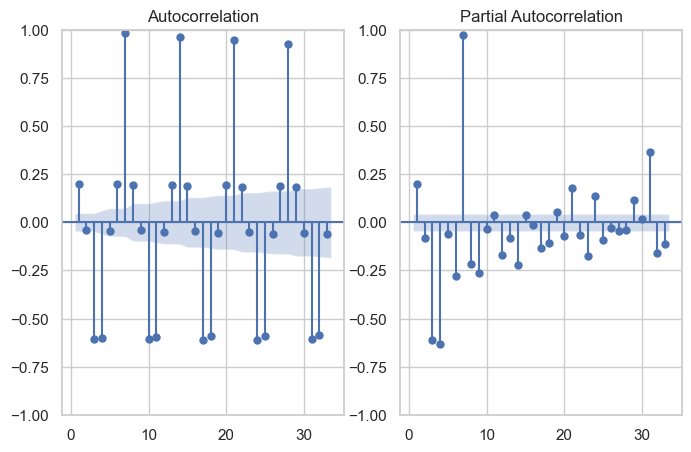

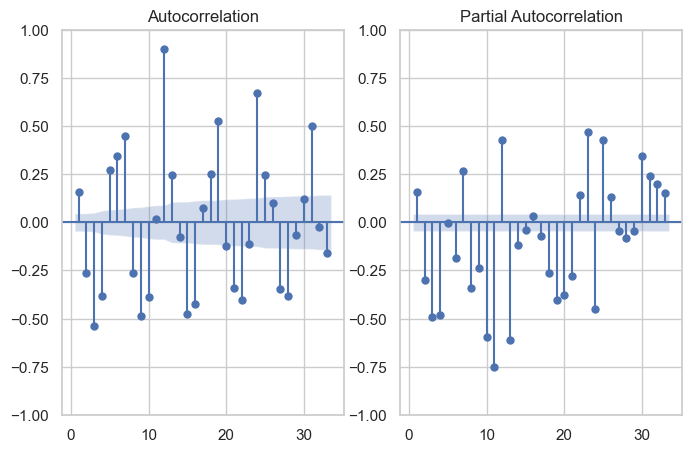

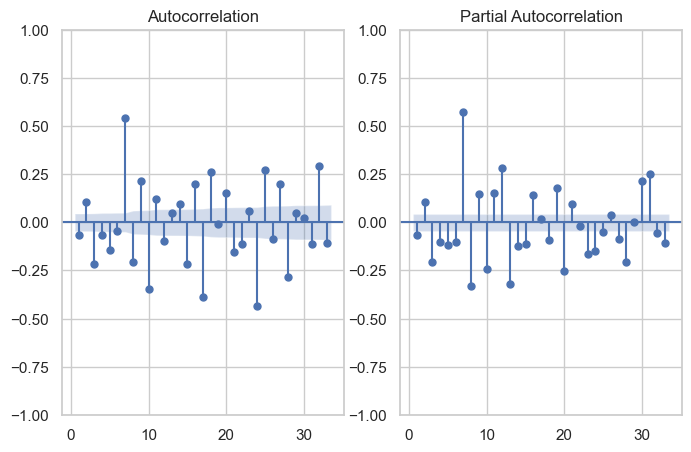

In [88]:
plot_acf_pacf(ts_diff2)
plot_acf_pacf(desc.seasonal['seasonal_12'])
plot_acf_pacf(desc.resid)

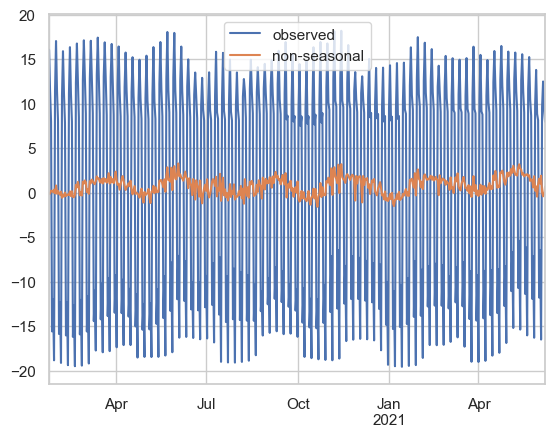

In [89]:
non_seasonal = desc.observed - desc.seasonal['seasonal_12'] - desc.seasonal['seasonal_7']

desc.observed[:500].plot()
non_seasonal[:500].plot()
plt.legend(['observed', 'non-seasonal'])

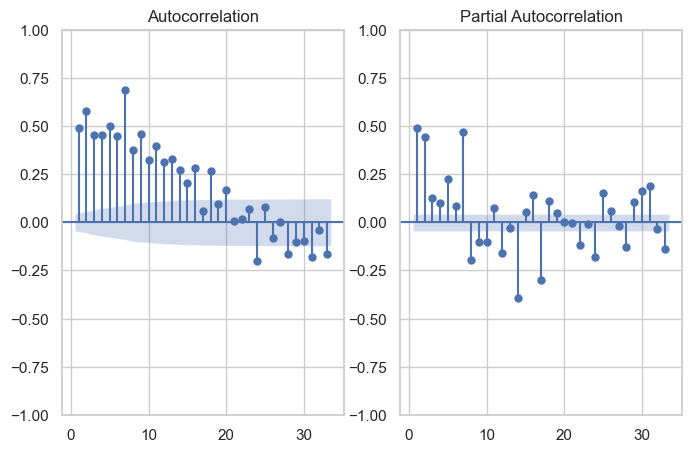

Results of Dickey-Fuller Test:
Test Statistic                -8.036903e+00
p-value                        1.892028e-12
#Lags Used                     2.500000e+01
Number of Observations Used    1.825000e+03
Critical Value (1%)           -3.433938e+00
Critical Value (5%)           -2.863125e+00
Critical Value (10%)          -2.567614e+00
dtype: float64
Stationary


In [90]:
plot_acf_pacf(non_seasonal)
adf_test(non_seasonal)

CPU times: total: 0 ns
Wall time: 0 ns


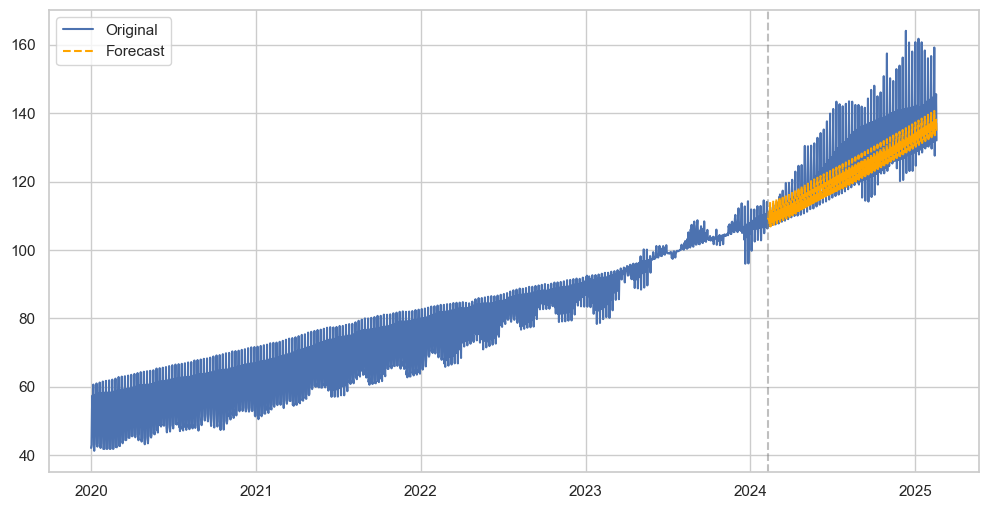

In [91]:
%time
split = int(len(ts) * 0.8)
train = ts.iloc[:split]
test = ts.iloc[split:]

model = SARIMAX(
    train,
    order=(12, 0, 2),
    seasonal_order=(0, 1, 2, 7),
    trend='t',
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)

N = len(test)
forecast = results.get_forecast(steps=N)
forecast_mean = forecast.predicted_mean

plt.figure(figsize=(12,6))
plt.plot(ts.index, ts, label='Original')
plt.plot(test.index, forecast_mean, linestyle='--', color='orange', label='Forecast')
plt.axvline(test.index[0], color='gray', linestyle='--', alpha=0.5)  # Línea separación train-test
plt.legend()
plt.show()


## 2. Modelos neuronales para series de tiempo

In [29]:
n_steps_in = 50
n_steps_out = 1

In [30]:
# Callback para todos los modelos
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

In [31]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    """
    Prepara datos de series de tiempo para predicción.

    Parameters:
        sequences: ndarray de forma (n, ) para univariado o (n, n_features) para multivariado
        n_steps_in: pasos usados como entrada
        n_steps_out: pasos a predecir

    Returns:
        X: entradas de forma (samples, n_steps_in[, n_features])
        y: salidas de forma (samples, n_steps_out[, n_features])
    """
    X, y = [], []
    for i in range(len(sequences) - n_steps_in - n_steps_out + 1):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#### a) Datos univariados:

In [32]:
data_uni = ts.values

# Crear secuencias
X_uni, y_uni = split_sequences(data_uni, n_steps_in=50, n_steps_out=1)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_uni, y_uni, test_size=0.2, random_state=42, shuffle=False
)

# Formatos para cada arquitectura

# MLP: (samples, 50)
X_train_mlp = X_train
X_test_mlp = X_test
y_train_mlp = y_train
y_test_mlp = y_test

# CNN: (samples, 50, 1)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]
y_train_cnn = y_train
y_test_cnn = y_test

# LSTM: (samples, 50, 1)
X_train_lstm = X_train[..., np.newaxis]
X_test_lstm = X_test[..., np.newaxis]
y_train_lstm = y_train
y_test_lstm = y_test

# ConvLSTM2D: (samples, 50, 1, 1, 1)
X_train_convlstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1, 1))
X_test_convlstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1, 1))
y_train_convlstm = y_train
y_test_convlstm = y_test

#### b) Datos multivariados:

In [33]:
data_multi = ts_multivar.values  # shape (2000, 19)

# Dividir en secuencias (ventanas deslizantes)
X_multi, y_multi = split_sequences(data_multi, n_steps_in=50, n_steps_out=1)
# X_multi: (samples, 50, 19)
# y_multi: (samples, 1, 19)

# Dividir en conjunto entrenamiento y prueba (80%-20%)
n_samples = X_multi.shape[0]
split_idx = int(n_samples * 0.8)

X_train_multi = X_multi[:split_idx]
X_test_multi = X_multi[split_idx:]

y_train_multi = y_multi[:split_idx]
y_test_multi = y_multi[split_idx:]

#Preparar datos para cada tipo de modelo

# MLP: aplanar tiempo y características (samples, 50*19)
X_train_mlp_multi = X_train_multi.reshape((X_train_multi.shape[0], X_train_multi.shape[1] * X_train_multi.shape[2]))
X_test_mlp_multi = X_test_multi.reshape((X_test_multi.shape[0], X_test_multi.shape[1] * X_test_multi.shape[2]))

# Salidas para MLP (samples, 19)
y_train_mlp_multi = y_train_multi.reshape((y_train_multi.shape[0], y_train_multi.shape[2]))
y_test_mlp_multi = y_test_multi.reshape((y_test_multi.shape[0], y_test_multi.shape[2]))

# CNN: mantener estructura (samples, 50, 19)
X_train_cnn_multi = X_train_multi
X_test_cnn_multi = X_test_multi

# LSTM: igual que CNN
X_train_lstm_multi = X_train_multi
X_test_lstm_multi = X_test_multi

# ConvLSTM2D: reshape a 5D (samples, 50, 1, 19, 1)
X_train_convlstm_multi = X_train_multi.reshape((X_train_multi.shape[0], X_train_multi.shape[1], 1, X_train_multi.shape[2], 1))
X_test_convlstm_multi = X_test_multi.reshape((X_test_multi.shape[0], X_test_multi.shape[1], 1, X_test_multi.shape[2], 1))

# Salidas para ConvLSTM2D (samples, 19)
y_train_convlstm_multi = y_train_multi.reshape((y_train_multi.shape[0], y_train_multi.shape[2]))
y_test_convlstm_multi = y_test_multi.reshape((y_test_multi.shape[0], y_test_multi.shape[2]))

#### **Multilayer Perceptron (MLP)**

#### a) Datos univariados:

In [34]:
# Diccionario para guardar resultados
mlp_uni_results = {}
mlp_uni_models = {}

# Modelos MLP univariados
def mlp_uni_model_1(input_shape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_uni_model_2(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_uni_model_3(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Diccionario con arquitecturas
mlp_uni_architectures = {
    "MLP_Uni_1": mlp_uni_model_1,
    "MLP_Uni_2": mlp_uni_model_2,
    "MLP_Uni_3": mlp_uni_model_3
}

for name, model_fn in mlp_uni_architectures.items():
    print(f"\nEntrenando {name}...")

    model = model_fn((X_train_mlp.shape[1],))

    history = model.fit(
        X_train_mlp, y_train_mlp,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_mlp)

    mse = mean_squared_error(y_test_mlp, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_mlp, y_pred)
    r2 = r2_score(y_test_mlp, y_pred)

    mlp_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    mlp_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando MLP_Uni_1...
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1185 - val_loss: 0.0243
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280 - val_loss: 0.0047
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0033
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━

#### b) Datos multivariados:

In [35]:
# Diccionarios para guardar resultados y modelos
mlp_multi_results = {}
mlp_multi_models = {}

# Definición de modelos
def mlp_multi_model_1(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(19))  # salida multivariada para 19 sensores
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_multi_model_2(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

def mlp_multi_model_3(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
mlp_multi_architectures = {
    "MLP_Multi_1": mlp_multi_model_1,
    "MLP_Multi_2": mlp_multi_model_2,
    "MLP_Multi_3": mlp_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in mlp_multi_architectures.items():
    print(f"\nEntrenando {name}...")

    model = model_fn((X_train_mlp_multi.shape[1],))

    history = model.fit(
        X_train_mlp_multi, y_train_mlp_multi,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_mlp_multi)

    mse = mean_squared_error(y_test_mlp_multi, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_mlp_multi, y_pred)
    r2 = r2_score(y_test_mlp_multi, y_pred)

    mlp_multi_results[name] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    mlp_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando MLP_Multi_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3585 
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0317
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 

#### **Convolutional Neural Network (CNN)**

#### a) Datos univariados: 

In [36]:
# Diccionarios para resultados y modelos
cnn_uni_results = {}
cnn_uni_models = {}

# Modelos CNN univariados
def cnn_uni_model_1(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_uni_model_2(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_uni_model_3(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
cnn_uni_architectures = {
    "CNN_Uni_1": cnn_uni_model_1,
    "CNN_Uni_2": cnn_uni_model_2,
    "CNN_Uni_3": cnn_uni_model_3
}

for name, model_fn in cnn_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    
    model = model_fn((X_train_cnn.shape[1], X_train_cnn.shape[2]))
    
    history = model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_cnn)

    mse = mean_squared_error(y_test_cnn, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_cnn, y_pred)
    r2 = r2_score(y_test_cnn, y_pred)

    cnn_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    cnn_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando CNN_Uni_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1018 - val_loss: 0.0094
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 - val_loss: 0.0029
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 6.8858e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3329e-04 - val_loss: 6.3603e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9732e-04 - val_loss: 6.9218e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4131e-04 - val_loss: 6.3610e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1220e-04 - val_loss: 6.3332e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0137e-04 - val_loss: 6.3112e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1781e-04 - val_loss: 6.1649e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2179e-04 -

#### b) Datos multivariados:

In [37]:
num_outputs = 19  # Número de salidas (features)

def cnn_multi_model_1(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Flatten(),
        Dense(num_outputs)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_multi_model_2(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_outputs)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def cnn_multi_model_3(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_outputs)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

cnn_multi_architectures = {
    "CNN_Multi_1": cnn_multi_model_1,
    "CNN_Multi_2": cnn_multi_model_2,
    "CNN_Multi_3": cnn_multi_model_3
}

cnn_multi_results = {}
cnn_multi_models = {}

for name, model_fn in cnn_multi_architectures.items():
    print(f"\nEntrenando {name}...")

    # Input shape para CNN: (50, 19)
    model = model_fn((X_train_cnn_multi.shape[1], X_train_cnn_multi.shape[2]))

    history = model.fit(
        X_train_cnn_multi,
        y_train_multi.reshape((y_train_multi.shape[0], num_outputs)),  # reshape a (samples, 19)
        validation_data=(
            X_test_cnn_multi,
            y_test_multi.reshape((y_test_multi.shape[0], num_outputs))  # reshape a (samples, 19)
        ),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_cnn_multi)

    y_pred_2d = y_pred.reshape(y_pred.shape[0], num_outputs)
    y_true_2d = y_test_multi.reshape(y_test_multi.shape[0], num_outputs)

    mse = mean_squared_error(y_true_2d, y_pred_2d)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_2d, y_pred_2d)
    r2 = r2_score(y_true_2d, y_pred_2d)

    cnn_multi_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    cnn_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando CNN_Multi_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2866 - val_loss: 0.0925
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 - val_loss: 0.0681
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - val_loss: 0.0548
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0182 - val_loss: 0.0451
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - val_loss: 0.0375
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - val_loss: 0.0361
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - val_loss: 0.0337
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - val_loss: 0.0306
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - val_loss: 0.0306
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - val_loss: 0.0283
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0145 - val_loss: 0.0274
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━

#### **Long Short-Term Memory (LSTM)**

#### a) Datos univariados:

In [38]:
# Diccionarios para guardar resultados y modelos
lstm_uni_results = {}
lstm_uni_models = {}

# Definición de modelos LSTM univariados
def lstm_uni_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_uni_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_uni_model_3(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_uni_architectures = {
    "LSTM_Uni_1": lstm_uni_model_1,
    "LSTM_Uni_2": lstm_uni_model_2,
    "LSTM_Uni_3": lstm_uni_model_3
}

for name, model_fn in lstm_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    
    model = model_fn((X_train_lstm.shape[1], X_train_lstm.shape[2]))
    
    history = model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_test_lstm, y_test_lstm),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_lstm)

    mse = mean_squared_error(y_test_lstm, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_lstm, y_pred)
    r2 = r2_score(y_test_lstm, y_pred)

    lstm_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    lstm_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando LSTM_Uni_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1304 - val_loss: 0.0020
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 9.3352e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 6.6975e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.0979e-04 - val_loss: 6.0432e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.1952e-04 - val_loss: 6.2256e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5941e-04 - val_loss: 6.3306e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5327e-04 - val_loss: 6.2181e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5842e-04 - val_loss: 6.1154e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7278e-04 - val_loss: 6.2752e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - lo

#### b) Datos multivariados:

In [39]:
num_outputs = 19

# Diccionarios para guardar resultados
lstm_multi_results = {}
lstm_multi_models = {}

# Estructuras de modelos LSTM
def lstm_multi_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(num_outputs))  # Salida multivariada
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_multi_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(num_outputs))
    model.compile(optimizer='adam', loss='mse')
    return model

def lstm_multi_model_3(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(num_outputs))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_multi_architectures = {
    "LSTM_Multi_1": lstm_multi_model_1,
    "LSTM_Multi_2": lstm_multi_model_2,
    "LSTM_Multi_3": lstm_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in lstm_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_multi.shape[1], X_train_multi.shape[2]))  # (50, 19)

    history = model.fit(
        X_train_multi,
        y_train_multi.reshape((y_train_multi.shape[0], num_outputs)),  # reshape a (samples, 19)
        validation_data=(
            X_test_multi,
            y_test_multi.reshape((y_test_multi.shape[0], num_outputs))   # reshape a (samples, 19)
        ),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_multi)

    # reshape para métricas
    y_pred_2d = y_pred.reshape(y_pred.shape[0], num_outputs)
    y_true_2d = y_test_multi.reshape(y_test_multi.shape[0], num_outputs)

    mse = mean_squared_error(y_true_2d, y_pred_2d)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_2d, y_pred_2d)
    r2 = r2_score(y_true_2d, y_pred_2d)

    lstm_multi_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    lstm_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando LSTM_Multi_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3607 - val_loss: 0.2009
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0736 - val_loss: 0.1141
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0298 - val_loss: 0.0711
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184 - val_loss: 0.0517
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0149 - val_loss: 0.0450
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0135 - val_loss: 0.0403
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0127 - val_loss: 0.0383
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0123 - val_loss: 0.0354
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0119 - val_loss: 0.0343
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0119 - val_loss: 0.0332
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0114 - val_loss: 0.0315
Epoch 12/100
49/49 ━━━━━

#### **Conv-LSTM**

#### a) Datos univariados:

In [40]:
# Diccionarios para resultados y modelos
convlstm_uni_results = {}
convlstm_uni_models = {}

def convlstm_uni_model_1(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_uni_model_2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_uni_model_3(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
convlstm_uni_architectures = {
    "ConvLSTM_Uni_1": convlstm_uni_model_1,
    "ConvLSTM_Uni_2": convlstm_uni_model_2,
    "ConvLSTM_Uni_3": convlstm_uni_model_3
}

for name, model_fn in convlstm_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn(X_train_convlstm.shape[1:])

    history = model.fit(
        X_train_convlstm, y_train_convlstm,
        validation_data=(X_test_convlstm, y_test_convlstm),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    y_pred = model.predict(X_test_convlstm)
    
    mse = mean_squared_error(y_test_convlstm, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_convlstm, y_pred)
    r2 = r2_score(y_test_convlstm, y_pred)

    convlstm_uni_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    convlstm_uni_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando ConvLSTM_Uni_1...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.2250 - val_loss: 0.0045
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0012 - val_loss: 7.8162e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 9.1094e-04 - val_loss: 6.5999e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.8240e-04 - val_loss: 6.2698e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.6419e-04 - val_loss: 6.5344e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.4332e-04 - val_loss: 6.3270e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.3070e-04 - val_loss: 7.1576e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.2761e-04 - val_loss: 0.0010
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 

#### b) Datos multivariados:

In [41]:
# Diccionarios para guardar resultados
convlstm_multi_results = {}
convlstm_multi_models = {}

def convlstm_multi_model_1(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_multi_model_2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

def convlstm_multi_model_3(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(19))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
convlstm_multi_architectures = {
    "ConvLSTM_Multi_1": convlstm_multi_model_1,
    "ConvLSTM_Multi_2": convlstm_multi_model_2,
    "ConvLSTM_Multi_3": convlstm_multi_model_3
}

for name, model_fn in convlstm_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn(X_train_convlstm_multi.shape[1:])  # shape = (50, 1, 19, 1)
    
    history = model.fit(
        X_train_convlstm_multi, y_train_convlstm_multi,
        validation_data=(X_test_convlstm_multi, y_test_convlstm_multi),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    
    y_pred = model.predict(X_test_convlstm_multi)
    
    # Métricas
    mse = mean_squared_error(y_test_convlstm_multi, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_convlstm_multi, y_pred)
    r2 = r2_score(y_test_convlstm_multi, y_pred)

    convlstm_multi_results[name] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "history": history.history
    }
    convlstm_multi_models[name] = model

    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Entrenando ConvLSTM_Multi_1...
Restoring model weights from the end of the best epoch: 92.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
ConvLSTM_Multi_1 - MSE: 0.0124 | RMSE: 0.1114 | MAE: 0.0888 | R2: 0.9764

Entrenando ConvLSTM_Multi_2...
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 73.
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
ConvLSTM_Multi_2 - MSE: 0.0149 | RMSE: 0.1221 | MAE: 0.0974 | R2: 0.9717

Entrenando ConvLSTM_Multi_3...
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 56.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
ConvLSTM_Multi_3 - MSE: 0.0160 | RMSE: 0.1265 | MAE: 0.1014 | R2: 0.9697


#### **Evaluación y predicciones de los modelos** 

##### Selección de los mejores modelos

In [42]:
best_mlp_uni = min(mlp_uni_results, key=lambda k: mlp_uni_results[k]['mse'])
best_cnn_uni = min(cnn_uni_results, key=lambda k: cnn_uni_results[k]['mse'])
best_lstm_uni = min(lstm_uni_results, key=lambda k: lstm_uni_results[k]['mse'])
best_convlstm_uni = min(convlstm_uni_results, key=lambda k: convlstm_uni_results[k]['mse'])

best_mlp_multi = min(mlp_multi_results, key=lambda k: mlp_multi_results[k]['mse'])
best_cnn_multi = min(cnn_multi_results, key=lambda k: cnn_multi_results[k]['mse'])
best_lstm_multi = min(lstm_multi_results, key=lambda k: lstm_multi_results[k]['mse'])
best_convlstm_multi = min(convlstm_multi_results, key=lambda k: convlstm_multi_results[k]['mse'])

In [43]:
print(f"Mejor modelo univariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_uni}, {best_cnn_uni}, {best_lstm_uni}, {best_convlstm_uni}")
print(f"Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_multi}, {best_cnn_multi}, {best_lstm_multi}, {best_convlstm_multi}")

Mejor modelo univariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Uni_3, CNN_Uni_2, LSTM_Uni_2, ConvLSTM_Uni_3
Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Multi_1, CNN_Multi_1, LSTM_Multi_1, ConvLSTM_Multi_1


In [ ]:
best_models = {
    'MLP Uni': mlp_uni_results[best_mlp_uni],
    'CNN Uni': cnn_uni_results[best_cnn_uni],
    'LSTM Uni': lstm_uni_results[best_lstm_uni],
    'ConvLSTM Uni': convlstm_uni_results[best_convlstm_uni],
    'MLP Multi': mlp_multi_results[best_mlp_multi],
    'CNN Multi': cnn_multi_results[best_cnn_multi],
    'LSTM Multi': lstm_multi_results[best_lstm_multi],
    'ConvLSTM Multi': convlstm_multi_results[best_convlstm_multi],
}

df_comparison = pd.DataFrame.from_dict(best_models, orient='index')
print(df_comparison)

                     mse      rmse       mae        r2  \
MLP Uni         0.000668  0.025845  0.020158  0.994831   
CNN Uni         0.000565  0.023767  0.018826  0.995628   
LSTM Uni        0.000580  0.024076  0.019136  0.995514   
ConvLSTM Uni    0.000593  0.024347  0.019331  0.995412   
MLP Multi       0.016134  0.127022  0.101076  0.969331   
CNN Multi       0.018252  0.135099  0.107553  0.965243   
LSTM Multi      0.021153  0.145441  0.114958  0.960128   
ConvLSTM Multi  0.012404  0.111375  0.088789  0.976408   

                                                          history  
MLP Uni         {'loss': [0.03826884552836418, 0.0009590153349...  
CNN Uni         {'loss': [0.030716359615325928, 0.000854674901...  
LSTM Uni        {'loss': [0.030793486163020134, 0.003318121191...  
ConvLSTM Uni    {'loss': [0.08345957100391388, 0.0040630833245...  
MLP Multi                                                     NaN  
CNN Multi       {'loss': [0.12463442236185074, 0.0242527723312...  
L

In [44]:
all_best_models_uni = {
    'MLP_Uni': best_mlp_uni,
    'CNN_Uni': best_cnn_uni,
    'LSTM_Uni': best_lstm_uni,
    'ConvLSTM_Uni': best_convlstm_uni,
}

In [45]:
all_best_models_multi = {
    'MLP_Multi': best_mlp_multi,
    'CNN_Multi': best_cnn_multi,
    'LSTM_Multi': best_lstm_multi,
    'ConvLSTM_Multi': best_convlstm_multi,
}

##### Predicciones para los modelos neuronales

In [46]:
# Mejor modelo univariado (Ejemplo con MLP)
best_mlp_model_uni = mlp_uni_models[best_mlp_uni]
y_pred_mlp_uni = best_mlp_model_uni.predict(X_test_mlp)

# Mejor modelo multivariado (Ejemplo con MLP)
best_mlp_model_multi = mlp_multi_models[best_mlp_multi]
y_pred_mlp_multi = best_mlp_model_multi.predict(X_test_mlp_multi)

# Mejor modelo univariado (Ejemplo con CNN)
best_cnn_model_uni = cnn_uni_models[best_cnn_uni]
y_pred_cnn_uni = best_cnn_model_uni.predict(X_test_cnn)

# Mejor modelo multivariado (Ejemplo con CNN)
best_cnn_model_multi = cnn_multi_models[best_cnn_multi]
y_pred_cnn_multi = best_cnn_model_multi.predict(X_test_multi)

# Mejor modelo univariado (Ejemplo con LSTM)
best_lstm_model_uni = lstm_uni_models[best_lstm_uni]
y_pred_lstm_uni = best_lstm_model_uni.predict(X_test_lstm)

# Mejor modelo multivariado (Ejemplo con LSTM)
best_lstm_model_multi = lstm_multi_models[best_lstm_multi]
y_pred_lstm_multi = best_lstm_model_multi.predict(X_test_multi)

# Mejor modelo univariado (Ejemplo con Conv-LSTM)
best_convlstm_model_uni = convlstm_uni_models[best_convlstm_uni]
y_pred_convlstm_uni = best_convlstm_model_uni.predict(X_test_convlstm)

# Mejor modelo multivariado (Ejemplo con Conv-LSTM)
best_convlstm_model_multi = convlstm_multi_models[best_convlstm_multi]
y_pred_convlstm_multi = best_convlstm_model_multi.predict(X_test_convlstm_multi)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


##### Gráficos de las predicciones de los datos univariados

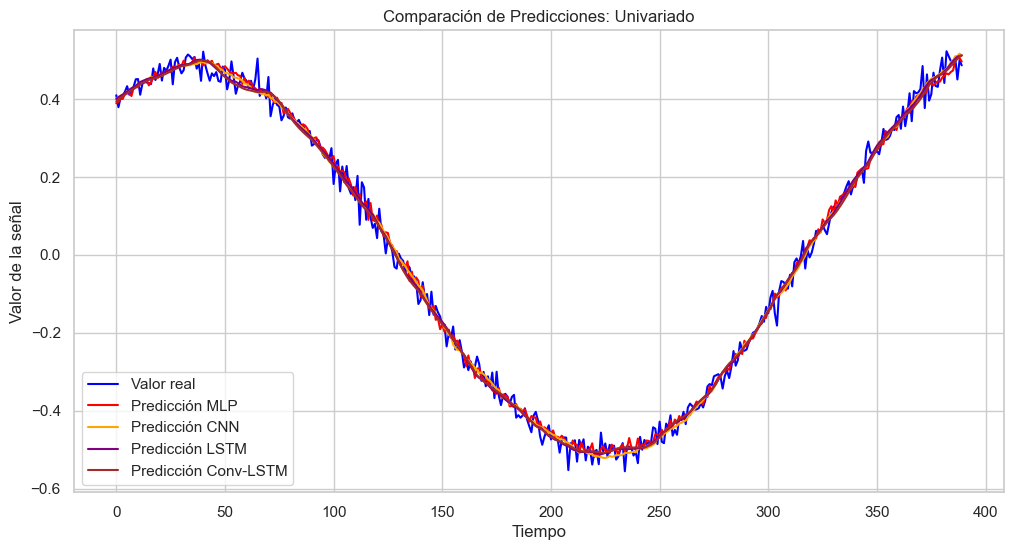

In [47]:
# Graficar predicciones univariadas
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valor real', color='blue')
plt.plot(y_pred_mlp_uni, label='Predicción MLP', color='red')
plt.plot(y_pred_cnn_uni, label='Predicción CNN', color='orange')
plt.plot(y_pred_lstm_uni, label='Predicción LSTM', color='purple')
plt.plot(y_pred_convlstm_uni, label='Predicción Conv-LSTM', color='brown')
plt.legend()
plt.title('Comparación de Predicciones: Univariado')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la señal')
plt.show()

##### Gráficos de las predicciones de los datos multivariados

In [48]:
y_multi = y_test_multi.squeeze(axis=1)

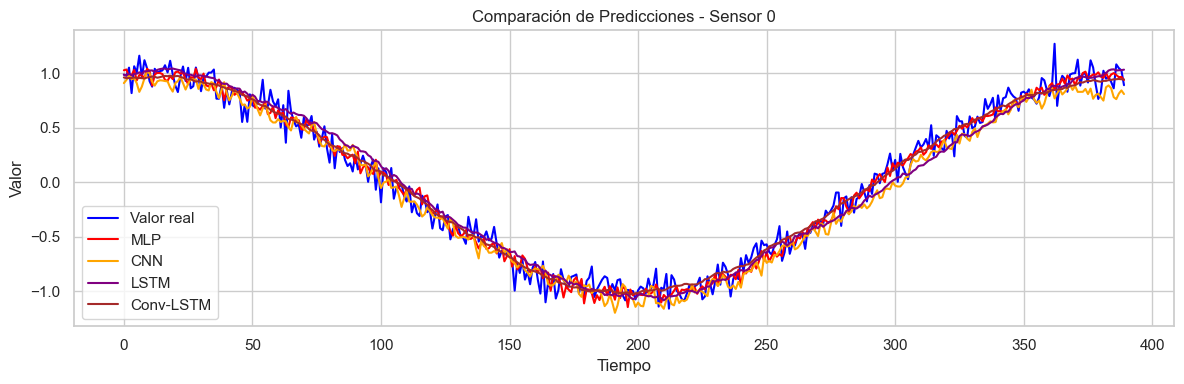

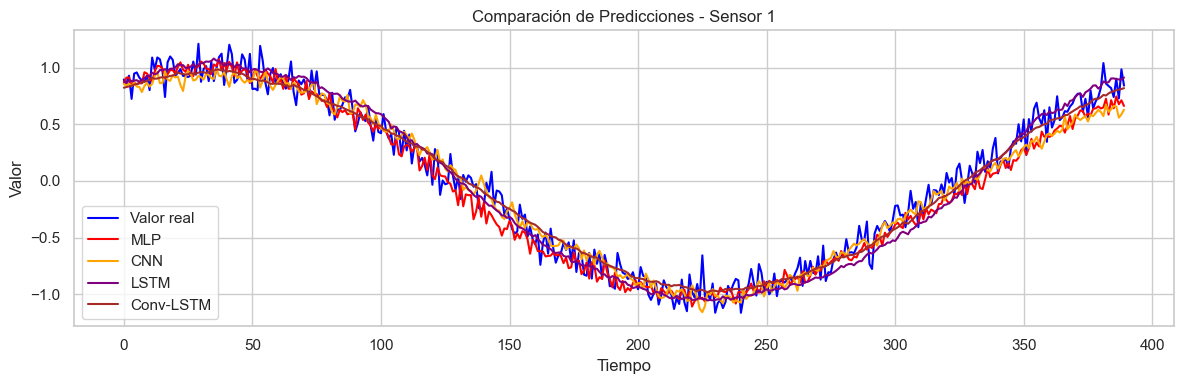

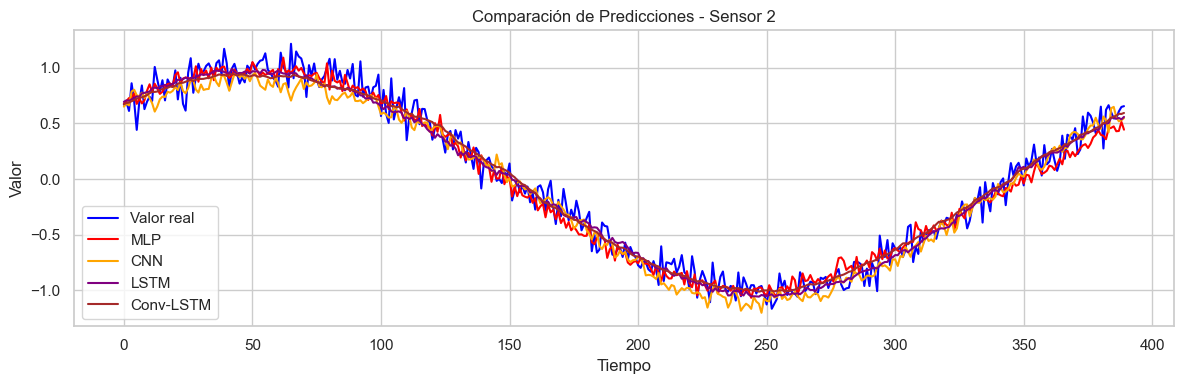

In [49]:
sensors_to_plot = [0, 1, 2]  # Índices de los primeros sensores

for i in sensors_to_plot:
    plt.figure(figsize=(12, 4))
    plt.plot(y_multi[:, i], label='Valor real', color='blue')
    plt.plot(y_pred_mlp_multi[:, i], label='MLP', color='red')
    plt.plot(y_pred_cnn_multi[:, i], label='CNN', color='orange')
    plt.plot(y_pred_lstm_multi[:, i], label='LSTM', color='purple')
    plt.plot(y_pred_convlstm_multi[:, i], label='Conv-LSTM', color='brown')
    plt.legend()
    plt.title(f'Comparación de Predicciones - Sensor {i}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.tight_layout()
    plt.show()

##### Optimización con Optuna

In [50]:
def get_mse(model_type, key):
    if 'Uni' in model_type:
        if 'MLP' in model_type:
            return mlp_uni_results[key]['mse']
        elif 'CNN' in model_type:
            return cnn_uni_results[key]['mse']
        elif 'ConvLSTM' in model_type:
            return convlstm_uni_results[key]['mse']
        elif 'LSTM' in model_type:
            return lstm_uni_results[key]['mse']
    else:
        if 'MLP' in model_type:
            return mlp_multi_results[key]['mse']
        elif 'CNN' in model_type:
            return cnn_multi_results[key]['mse']
        elif 'ConvLSTM' in model_type:
            return convlstm_multi_results[key]['mse']
        elif 'LSTM' in model_type:
            return lstm_multi_results[key]['mse']

# Mejor modelo univariado global
best_uni_global = min(all_best_models_uni.items(), key=lambda x: get_mse(x[0], x[1]))
# Mejor modelo multivariado global
best_multi_global = min(all_best_models_multi.items(), key=lambda x: get_mse(x[0], x[1]))

print(f"Mejor modelo univariado global: {best_uni_global[0]} con key {best_uni_global[1]} y MSE {get_mse(best_uni_global[0], best_uni_global[1])}")
print(f"Mejor modelo multivariado global: {best_multi_global[0]} con key {best_multi_global[1]} y MSE {get_mse(best_multi_global[0], best_multi_global[1])}")

Mejor modelo univariado global: CNN_Uni con key CNN_Uni_2 y MSE 0.0005648876770550508
Mejor modelo multivariado global: ConvLSTM_Multi con key ConvLSTM_Multi_1 y MSE 0.012404483689181959


Con los dos mejores modelos globales obtenidos, tanto para los datos univariados como para los multivariados, procederemos a realizar la optimización utilizando Optuna.

In [51]:
def build_cnn_uni_model(input_shape, n_filters, kernel_size, learning_rate):
    model = Sequential()
    model.add(Conv1D(n_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(Conv1D(n_filters // 2, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # salida univariada
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def build_convlstm_multi_model(input_shape, filters, kernel_size, learning_rate):
    model = Sequential()
    model.add(ConvLSTM2D(filters=filters, kernel_size=(1, kernel_size), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(19))  # salida multivariada con 19 variables
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective_cnn(trial):
    n_filters = trial.suggest_int('n_filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = build_cnn_uni_model(X_train_cnn.shape[1:], n_filters, kernel_size, learning_rate)
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    
    val_mse = min(history.history['val_loss'])
    return val_mse

def objective_convlstm(trial):
    filters = trial.suggest_int('filters', 16, 64)
    kernel_size = trial.suggest_int('kernel_size', 1, 3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = build_convlstm_multi_model(X_train_convlstm_multi.shape[1:], filters, kernel_size, learning_rate)
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_convlstm_multi, y_train_convlstm_multi,
        validation_data=(X_test_convlstm_multi, y_test_convlstm_multi),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    
    val_mse = min(history.history['val_loss'])
    return val_mse

study_cnn = optuna.create_study(direction='minimize')
study_cnn.optimize(objective_cnn, n_trials=15)

print("Mejores hiperparámetros CNN univariado:", study_cnn.best_params)
print("Mejor MSE CNN univariado:", study_cnn.best_value)

study_convlstm = optuna.create_study(direction='minimize')
study_convlstm.optimize(objective_convlstm, n_trials=15)

print("Mejores hiperparámetros ConvLSTM multivariado:", study_convlstm.best_params)
print("Mejor MSE ConvLSTM multivariado:", study_convlstm.best_value)

[I 2025-05-15 19:18:50,515] A new study created in memory with name: no-name-20f1c797-4062-479f-b8ad-0c798a8c629d
[I 2025-05-15 19:18:56,094] Trial 0 finished with value: 0.0006719022057950497 and parameters: {'n_filters': 23, 'kernel_size': 3, 'learning_rate': 0.007769406851750783}. Best is trial 0 with value: 0.0006719022057950497.
[I 2025-05-15 19:19:10,431] Trial 1 finished with value: 0.000629725749604404 and parameters: {'n_filters': 58, 'kernel_size': 2, 'learning_rate': 1.6598001092329653e-05}. Best is trial 1 with value: 0.000629725749604404.
[I 2025-05-15 19:19:14,474] Trial 2 finished with value: 0.0005828366265632212 and parameters: {'n_filters': 56, 'kernel_size': 4, 'learning_rate': 0.004722168881395404}. Best is trial 2 with value: 0.0005828366265632212.
[I 2025-05-15 19:19:18,303] Trial 3 finished with value: 0.0005680691683664918 and parameters: {'n_filters': 38, 'kernel_size': 2, 'learning_rate': 0.009644955164686931}. Best is trial 3 with value: 0.0005680691683664918

Mejores hiperparámetros CNN univariado: {'n_filters': 38, 'kernel_size': 2, 'learning_rate': 0.009644955164686931}
Mejor MSE CNN univariado: 0.0005680691683664918


[I 2025-05-15 19:22:47,681] Trial 0 finished with value: 0.016062462702393532 and parameters: {'filters': 39, 'kernel_size': 2, 'learning_rate': 0.0001985106102503681}. Best is trial 0 with value: 0.016062462702393532.
[I 2025-05-15 19:24:37,609] Trial 1 finished with value: 0.013713742606341839 and parameters: {'filters': 21, 'kernel_size': 1, 'learning_rate': 0.0009129250701405502}. Best is trial 1 with value: 0.013713742606341839.
[I 2025-05-15 19:26:25,157] Trial 2 finished with value: 0.016203010454773903 and parameters: {'filters': 47, 'kernel_size': 2, 'learning_rate': 0.0006410605884426696}. Best is trial 1 with value: 0.013713742606341839.
[I 2025-05-15 19:29:53,054] Trial 3 finished with value: 0.016628218814730644 and parameters: {'filters': 48, 'kernel_size': 2, 'learning_rate': 0.00011651246812682238}. Best is trial 1 with value: 0.013713742606341839.
[I 2025-05-15 19:32:03,359] Trial 4 finished with value: 0.015649011358618736 and parameters: {'filters': 21, 'kernel_size'

Mejores hiperparámetros ConvLSTM multivariado: {'filters': 28, 'kernel_size': 1, 'learning_rate': 0.0015787005259683394}
Mejor MSE ConvLSTM multivariado: 0.013243980705738068


In [52]:
# Optuna para CNN univariado:
best_params = study_cnn.best_params

model_final = build_cnn_uni_model(
    input_shape=X_train_cnn.shape[1:],
    n_filters=best_params['n_filters'],
    kernel_size=best_params['kernel_size'],
    learning_rate=best_params['learning_rate']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)
]

history = model_final.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

test_mse = model_final.evaluate(X_test_cnn, y_test_cnn)
print(f"MSE final en test: {test_mse:.6f}")

Epoch 1/100
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0750

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0703 - val_loss: 0.0011
Epoch 2/100
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 7.8213e-04
Epoch 3/100
38/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031   

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 6.3626e-04
Epoch 4/100
42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7291e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8259e-04 - val_loss: 6.0792e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7628e-04 - val_loss: 6.5671e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7449e-04 - val_loss: 9.0811e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 8.4376e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 8.2299e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3880e-04 - val_loss: 7.3639e-04
Epoch 10/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5997e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6035e-04 - val_loss: 5.5982e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0380e-04 - val_loss: 6.6119e-04
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9166e-04 - val_loss: 0.0011
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 6.6073e-04
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1532e-04 - val_loss: 6.5630e-04
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 6.4260e-04
Epoch 16/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 6.2215e-04
Epoch 17/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 18/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 19/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9858e-04 - val_loss: 8.3262e-04
Epoch 20/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 6.4357e-04
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


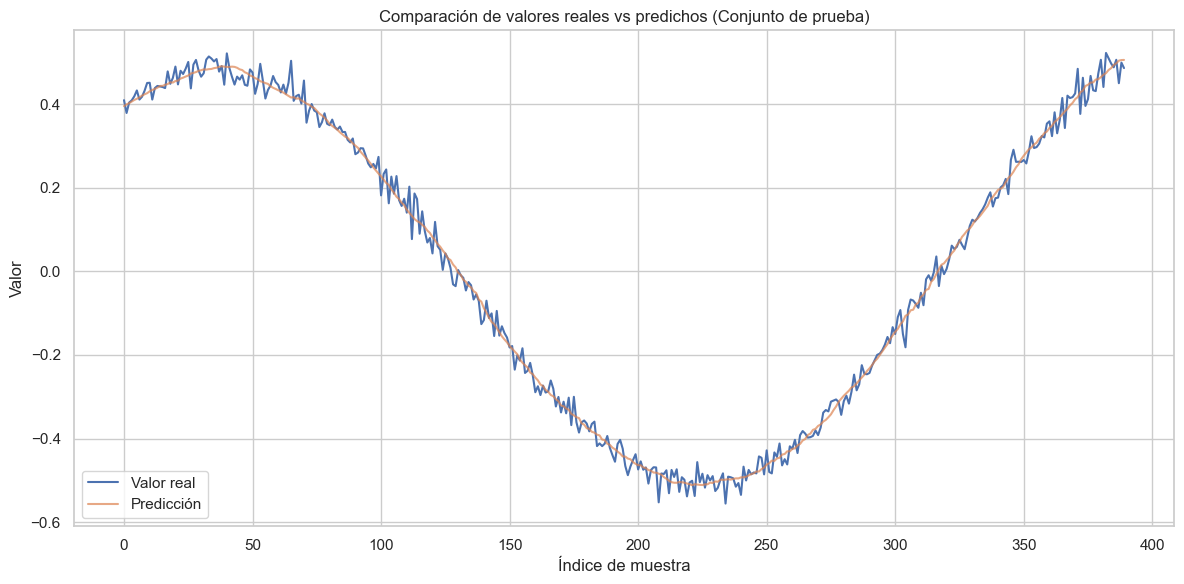

In [53]:
y_pred = model_final.predict(X_test_cnn)

# Aplanar si es necesario (en caso de que los resultados tengan dimensión (n,1))
y_pred = y_pred.flatten()
y_true = y_test_cnn.flatten()

# Graficar valores reales vs predichos
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Valor real')
plt.plot(y_pred, label='Predicción', alpha=0.7)
plt.title('Comparación de valores reales vs predichos (Conjunto de prueba)')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# Optuna para ConvLSTM multivariado:
best_params_convlstm = study_convlstm.best_params

model_final_convlstm = build_convlstm_multi_model(
    input_shape=X_train_convlstm_multi.shape[1:],
    filters=best_params_convlstm['filters'],
    kernel_size=best_params_convlstm['kernel_size'],
    learning_rate=best_params_convlstm['learning_rate']
)

callbacks_convlstm = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_convlstm_model.h5', monitor='val_loss', save_best_only=True)
]

history_convlstm = model_final_convlstm.fit(
    X_train_convlstm_multi, y_train_convlstm_multi,
    validation_data=(X_test_convlstm_multi, y_test_convlstm_multi),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_convlstm,
    verbose=1
)

test_mse_convlstm = model_final_convlstm.evaluate(X_test_convlstm_multi, y_test_convlstm_multi)
print(f"MSE final en test ConvLSTM multivariado: {test_mse_convlstm:.6f}")

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2876

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.2848 - val_loss: 0.1073
Epoch 2/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0199

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0197 - val_loss: 0.0283
Epoch 3/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0120

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0120 - val_loss: 0.0248
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0116 - val_loss: 0.0251
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0115

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0115 - val_loss: 0.0233
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0114

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0114 - val_loss: 0.0218
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0114

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0114 - val_loss: 0.0206
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0112 - val_loss: 0.0214
Epoch 9/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0115

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0115 - val_loss: 0.0195
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0111 - val_loss: 0.0197
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0111

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0111 - val_loss: 0.0179
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0112 - val_loss: 0.0181
Epoch 13/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0109

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0109 - val_loss: 0.0170
Epoch 14/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0111

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0111 - val_loss: 0.0170
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0110 - val_loss: 0.0177
Epoch 16/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0110

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0110 - val_loss: 0.0164
Epoch 17/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0110 - val_loss: 0.0168
Epoch 18/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0110 - val_loss: 0.0165
Epoch 19/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0108

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0108 - val_loss: 0.0155
Epoch 20/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0108 - val_loss: 0.0159
Epoch 21/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0107

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0107 - val_loss: 0.0155
Epoch 22/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0109 - val_loss: 0.0163
Epoch 23/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0107

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0108 - val_loss: 0.0154
Epoch 24/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0108

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0108 - val_loss: 0.0151
Epoch 25/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0110 - val_loss: 0.0155
Epoch 26/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0110

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0110 - val_loss: 0.0150
Epoch 27/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0106

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0107 - val_loss: 0.0144
Epoch 28/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0106 - val_loss: 0.0145
Epoch 29/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0106 - val_loss: 0.0152
Epoch 30/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0107

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0107 - val_loss: 0.0144
Epoch 31/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0109 - val_loss: 0.0148
Epoch 32/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0108 - val_loss: 0.0148
Epoch 33/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0108 - val_loss: 0.0146
Epoch 34/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0106 - val_loss: 0.0147
Epoch 35/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0107

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0107 - val_loss: 0.0142
Epoch 36/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0105 - val_loss: 0.0147
Epoch 37/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0106 - val_loss: 0.0143
Epoch 38/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0105 - val_loss: 0.0144
Epoch 39/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0107

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0107 - val_loss: 0.0141
Epoch 40/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0106 - val_loss: 0.0144
Epoch 41/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0106

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0106 - val_loss: 0.0141
Epoch 42/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0106 - val_loss: 0.0142
Epoch 43/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0107

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0107 - val_loss: 0.0139
Epoch 44/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0105

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0105 - val_loss: 0.0137
Epoch 45/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0105 - val_loss: 0.0142
Epoch 46/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0108 - val_loss: 0.0138
Epoch 47/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0106

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 48/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0105 - val_loss: 0.0136
Epoch 49/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0106 - val_loss: 0.0138
Epoch 50/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0107 - val_loss: 0.0137
Epoch 51/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0108 - val_loss: 0.0137
Epoch 52/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0106 - val_loss: 0.0137
Epoch 53/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0105 - val_loss: 0.0134
Epoch 54/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0105 - val_loss: 0.0138
Epoch 55/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0105

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 56/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0104

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0104 - val_loss: 0.0132
Epoch 57/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 58/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0103 - val_loss: 0.0138
Epoch 59/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 60/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0106

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0106 - val_loss: 0.0129
Epoch 61/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0104 - val_loss: 0.0134
Epoch 62/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 63/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0103 - val_loss: 0.0133
Epoch 64/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0105 - val_loss: 0.0140
Epoch 65/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 66/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0104 - val_loss: 0.0131
Epoch 67/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0105 - val_loss: 0.0135
Epoch 68/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 69/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 70/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0105 - val_loss: 0.0133
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0124
M

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


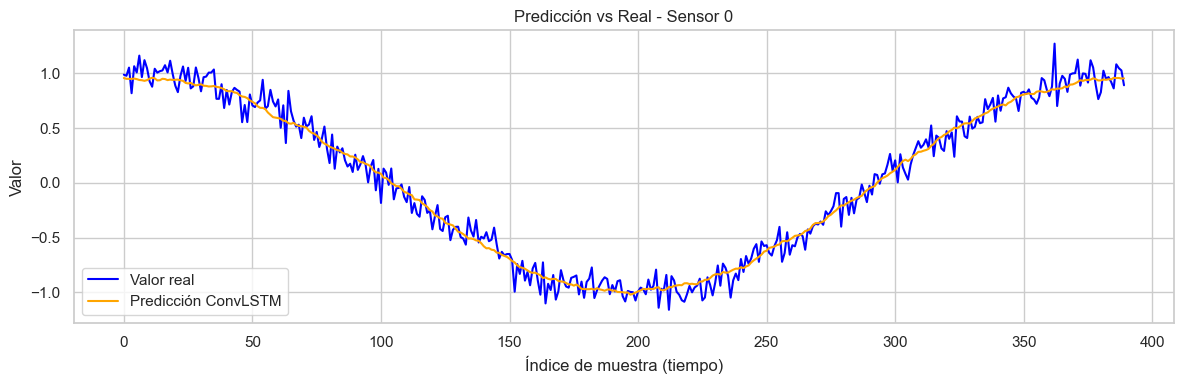

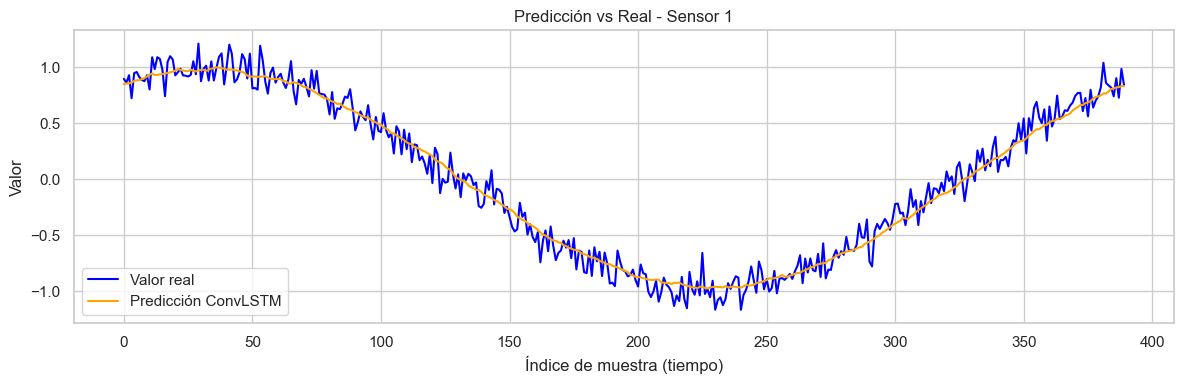

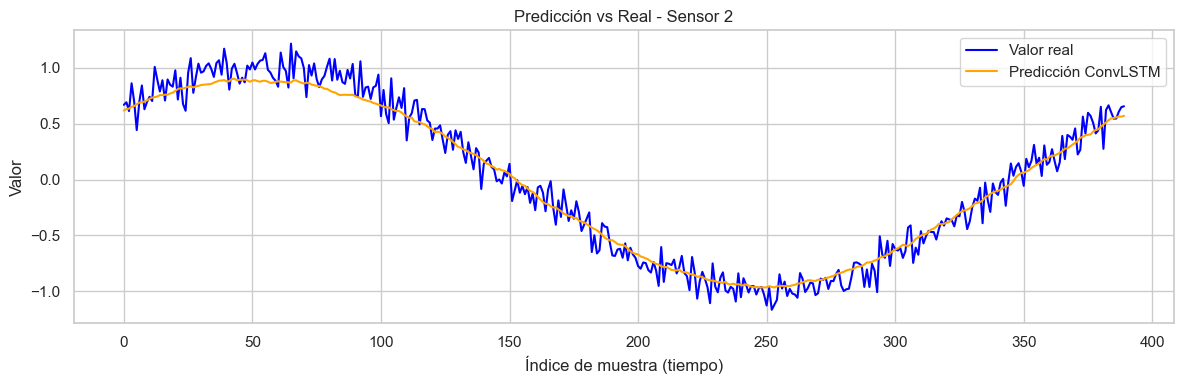

In [55]:
y_pred_convlstm_multi = model_final_convlstm.predict(X_test_convlstm_multi)

y_true = y_test_convlstm_multi
y_pred = y_pred_convlstm_multi

sensors_to_plot = [0, 1, 2]

# Graficar
for i in sensors_to_plot:
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[:, i], label='Valor real', color='blue')
    plt.plot(y_pred[:, i], label='Predicción ConvLSTM', color='orange')
    plt.title(f'Predicción vs Real - Sensor {i}')
    plt.xlabel('Índice de muestra (tiempo)')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3. Clasificación de series de tiempo

In [56]:
# ----------------------------
# Entrenamiento y evaluación
# ----------------------------
def train_and_eval(model_fn, X_train, X_test, y_train, y_test, nombre):
    print(f"\nEntrenando modelo: {nombre}")
    model = model_fn()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_true = y_test

    report = classification_report(y_true, y_pred)
    print(f" Reporte de clasificación para {nombre}:\n{report}")

    return report

def train_and_eval2(model_fn, X_train, X_test, y_train, y_test, nombre):
    print(f"\nEntrenando modelo: {nombre}")
    model = model_fn()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_true = np.argmax(y_test, axis=-1)

    report = classification_report(y_true, y_pred)
    print(f" Reporte de clasificación para {nombre}:\n{report}")

    return report

In [57]:
# Etiquetas one-hot
num_classes = len(np.unique(y_train))

#### **MLP para clasificación**

In [ ]:
def basic_mlp():
    model = Sequential([
        Input(shape=(2000,)),  # Entrada 1D
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Multiclase
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def deep_mlp():
    model = Sequential([
        Input(shape=(2000,)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mlp_with_dropout():
    model = Sequential([
        Input(shape=(2000,)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_basic_mlp = train_and_eval2(basic_mlp, X_train, X_test, y_train, y_test, "MLP Básico")

In [ ]:
model_deep_mlp = train_and_eval2(deep_mlp, X_train, X_test, y_train, y_test, "MLP Profundo")

In [ ]:
model_dropout_mlp = train_and_eval2(mlp_with_dropout, X_train, X_test, y_train, y_test, "MLP con Dropout")

#### **CNN para clasificación**

In [64]:
n = 0
u = 0

for i in X_train:
  if len(i) == 2000:
    n += 1
  else:
    u += 1

n, u

(0, 1560)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df.wave_mean, df.label, test_size=0.2, random_state=42, shuffle=True
)

# X_train a array 2D real (de listas a ndarray)
X_train = np.array([np.array(xi) for xi in X_train], dtype='float32')
X_test = np.array([np.array(xi) for xi in X_test], dtype='float32')

print(X_train.shape)  # debería ser algo como (80, 200)

# Reshape para Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)  # (80, 200, 1)

(80, 2000)
(80, 2000, 1)


In [67]:
# ----------------------------
# 1. CNN Básica (Conv1D)
# ----------------------------
def basic_cnn():
    model = Sequential([
        Input(shape=(2000, 1)),  # ← Asegúrate que 2000 coincide con tu input
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # O 'softmax' si tienes más clases
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# 2. CNN Profunda (Conv2D)
# ----------------------------
def deep_cnn():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(40, 50, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # usa la variable real
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# 3. CNN con Dropout (Conv2D)
# ----------------------------
def cnn_with_dropout():
    model = Sequential([
        Conv2D(32, (3, 1), activation='relu', input_shape=(2000, 1, 1)),
        MaxPooling2D(pool_size=(2, 1)),
        Dropout(0.25),
        Conv2D(64, (3, 1), activation='relu'),
        MaxPooling2D(pool_size=(2, 1)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [68]:
acc_basic = train_and_eval(basic_cnn, X_train, X_test, y_train, y_test, "CNN Básica (Conv1D)")


Entrenando modelo: CNN Básica (Conv1D)
Epoch 1/10
3/3 - 2s - 644ms/step - accuracy: 0.4000 - loss: -2.3171e+00
Epoch 2/10
3/3 - 0s - 71ms/step - accuracy: 0.6750 - loss: -1.3295e+01
Epoch 3/10
3/3 - 0s - 110ms/step - accuracy: 0.6500 - loss: -2.4711e+01
Epoch 4/10
3/3 - 0s - 75ms/step - accuracy: 0.6750 - loss: -4.1471e+01
Epoch 5/10
3/3 - 0s - 95ms/step - accuracy: 0.6750 - loss: -5.9964e+01
Epoch 6/10
3/3 - 0s - 74ms/step - accuracy: 0.6000 - loss: -7.9323e+01
Epoch 7/10
3/3 - 0s - 67ms/step - accuracy: 0.6750 - loss: -1.0399e+02
Epoch 8/10
3/3 - 0s - 69ms/step - accuracy: 0.6250 - loss: -1.3157e+02
Epoch 9/10
3/3 - 0s - 91ms/step - accuracy: 0.6250 - loss: -1.6615e+02
Epoch 10/10
3/3 - 0s - 121ms/step - accuracy: 0.6125 - loss: -2.0323e+02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
 Reporte de clasificación para CNN Básica (Conv1D):
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         5
           1       0.00      0.00      0.00   

In [69]:
# Datos redimensionados
X_train_cnn2d = X_train.reshape((X_train.shape[0], 40, 50, 1))
X_test_cnn2d = X_test.reshape((X_test.shape[0], 40, 50, 1))

y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)

In [70]:
acc_deep = train_and_eval2(deep_cnn, X_train_cnn2d, X_test_cnn2d, y_train_ohe, y_test_ohe, "CNN Profunda (Conv2D)")


Entrenando modelo: CNN Profunda (Conv2D)
Epoch 1/10
3/3 - 2s - 562ms/step - accuracy: 0.3750 - loss: 6.9050
Epoch 2/10
3/3 - 0s - 56ms/step - accuracy: 1.0000 - loss: 3.0624
Epoch 3/10
3/3 - 0s - 59ms/step - accuracy: 1.0000 - loss: 0.1679
Epoch 4/10
3/3 - 0s - 54ms/step - accuracy: 1.0000 - loss: 0.0146
Epoch 5/10
3/3 - 0s - 64ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 6/10
3/3 - 0s - 61ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 7/10
3/3 - 0s - 58ms/step - accuracy: 1.0000 - loss: 1.6674e-04
Epoch 8/10
3/3 - 0s - 63ms/step - accuracy: 1.0000 - loss: 2.5462e-05
Epoch 9/10
3/3 - 0s - 80ms/step - accuracy: 1.0000 - loss: 5.6505e-06
Epoch 10/10
3/3 - 0s - 61ms/step - accuracy: 1.0000 - loss: 2.1741e-06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
 Reporte de clasificación para CNN Profunda (Conv2D):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00 

In [ ]:
acc_dropout = train_and_eval(cnn_with_dropout, X_train, X_test, y_train, y_test, "CNN con Dropout (Conv2D)")

#### **LSTM para clasificación**

In [72]:
# ----------------------------
# 1. LSTM
# ----------------------------
def lstm_model():
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(18286, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [73]:
acc_lstm = train_and_eval(lstm_model, X_train, X_test, y_train, y_test, "LSTM")


Entrenando modelo: LSTM
Epoch 1/10
3/3 - 5s - 2s/step - accuracy: 0.2500 - loss: 1.3752
Epoch 2/10
3/3 - 5s - 2s/step - accuracy: 0.4875 - loss: 1.3613
Epoch 3/10
3/3 - 3s - 992ms/step - accuracy: 0.4000 - loss: 1.3393
Epoch 4/10
3/3 - 2s - 815ms/step - accuracy: 0.5000 - loss: 1.3241
Epoch 5/10
3/3 - 2s - 789ms/step - accuracy: 0.4875 - loss: 1.2893
Epoch 6/10
3/3 - 3s - 844ms/step - accuracy: 0.4625 - loss: 1.3163
Epoch 7/10
3/3 - 2s - 778ms/step - accuracy: 0.3500 - loss: 1.3782
Epoch 8/10
3/3 - 2s - 781ms/step - accuracy: 0.3500 - loss: 1.3770
Epoch 9/10
3/3 - 2s - 794ms/step - accuracy: 0.3500 - loss: 1.3758
Epoch 10/10
3/3 - 3s - 915ms/step - accuracy: 0.3500 - loss: 1.3745


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
 Reporte de clasificación para LSTM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.40      1.00      0.57         8
           2       0.00      0.00      0.00         7

    accuracy                           0.40        20
   macro avg       0.13      0.33      0.19        20
weighted avg       0.16      0.40      0.23        20



#### **CNN-LSTM para clasificación**

In [74]:
# ----------------------------
# 1. CNN-LSTM
# ----------------------------
def cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(2000, 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ----------------------------
# 2. ConvLSTM
# ----------------------------

def conv_lstm_model():
    with tf.device('/GPU:0'):  # Fuerza uso de GPU
        model = Sequential()
        model.add(ConvLSTM2D(64, (3, 1), activation='relu', input_shape=(1, 2000, 1, 1), return_sequences=True))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 1))))
        model.add(ConvLSTM2D(128, (3, 1), activation='relu', return_sequences=False))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4, activation='softmax'))
        model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
X_train_conv_lstm = X_train.reshape((X_train.shape[0], 1, 2000, 1, 1))
X_test_conv_lstm = X_test.reshape((X_test.shape[0], 1, 2000, 1, 1))

In [76]:
acc_conv_lstm = train_and_eval(conv_lstm_model, X_train_conv_lstm, X_test_conv_lstm, y_train, y_test, "ConvLSTM2D")


Entrenando modelo: ConvLSTM2D
Epoch 1/10
3/3 - 11s - 4s/step - accuracy: 0.3750 - loss: 1.3525
Epoch 2/10
3/3 - 3s - 1s/step - accuracy: 0.8125 - loss: 1.0370
Epoch 3/10
3/3 - 3s - 920ms/step - accuracy: 0.8875 - loss: 0.6171
Epoch 4/10
3/3 - 5s - 2s/step - accuracy: 0.9000 - loss: 0.2890
Epoch 5/10
3/3 - 2s - 808ms/step - accuracy: 0.9500 - loss: 0.1394
Epoch 6/10
3/3 - 3s - 893ms/step - accuracy: 0.9750 - loss: 0.0737
Epoch 7/10
3/3 - 3s - 909ms/step - accuracy: 0.9375 - loss: 0.1337
Epoch 8/10
3/3 - 3s - 912ms/step - accuracy: 0.9625 - loss: 0.0446
Epoch 9/10
3/3 - 3s - 1s/step - accuracy: 0.9625 - loss: 0.0727
Epoch 10/10
3/3 - 4s - 1s/step - accuracy: 1.0000 - loss: 0.0071


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
 Reporte de clasificación para ConvLSTM2D:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         7

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



#### **Algoritmos clásicos de Machine Learning (SVM, Random Forest, etc.)**

In [77]:
X = np.stack(df.wave_mean.values)  # shape (num_samples, features)

X_train, X_test, y_train, y_test = train_test_split(
    X, df.label.values, test_size=0.2, random_state=42, shuffle=False
)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "K-NN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 1.0000
SVM Accuracy: 1.0000
K-NN Accuracy: 1.0000
XGBoost Accuracy: 1.0000
